In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import SimultaneousActivation
import random

# Agentes

## Itens

In [78]:
class Item(Agent):
    def __init__(self, model, item_type, pontos):
        super().__init__(model)
        self.type = item_type
        self.nome = item_type
        self.pontos = pontos
        self.carregado_por = []

    def step(self):
        pass

## Agente Reativo Simples

In [69]:
class ReativoSimples(Agent):
    def __init__(self, model):
        super().__init__(model)
        self.has_item = False
        self.item = None
        self.contribuicao = 0
        self.num_contribuicao = 0
        self.nome = f"AR{self.unique_id}"

    def pegar_item(self, item):
        if (item.type == "Cristal Energético" or item.type == "Metal Raro") and len(item.carregado_por) == 0:
            self.has_item = True
            self.item = item
            item.carregado_por = [self]
            self.model.agent_bdi.recurso_coletado(item)
            print(f"{self.nome} pegou recurso: {self.item.nome}{self.item.unique_id}")

        #elif item.type == "Estrutura Antiga" and len(item.carregado_por) < 2:
        #    item.carregado_por.append(self)
        #    if len(item.carregado_por) == 2:
        #        for agent in item.carregado_por:
        #            agent.has_item = True
        #            agent.item = item

    def entregar_item(self):
        if self.item:
            self.contribuicao += self.item.pontos
            self.num_contribuicao += 1
            #if self.item.type == "Cristal Energético" or self.item.type == "Metal Raro":
            
            self.has_item = False
            self.item.carregado_por = []
            self.model.remove_item(self.item)
            self.item = None

            #elif self.item.type == "Estrutura Antiga":
            #    if self in self.item.carregado:
            #      self.item.carregado.remove(self)
            #    if not self.item.carregado:
            #        self.item = None

    def verificar_item(self, possiveis_passos):
        tem = False
        passo_ = None
        item = None
        for passo in possiveis_passos:
            itens = [obj for obj in self.model.grid.get_cell_list_contents([passo]) if isinstance(obj, Item)]
            for possivel_item in itens:
                if possivel_item.type != "Estrutura Antiga" and len(possivel_item.carregado_por) == 0:
                    tem = True
                    item = possivel_item
                    break
            if tem:
                passo_ = passo
                break
        return item, passo_

    def step(self):
        #if self.has_item:
        #    self.move_towards(self.model.destination)
        #    if self.pos == self.model.destination:
        #        print(f"Agent {self.unique_id} delivered the item!")
        #        self.drop_item()
        #else:
        if self.item != None:
            print(f"{self.nome} tem: {self.item.nome}{self.item.unique_id}")
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        bdi = self.model.agent_bdi
        #possible_steps = [pos for pos in possible_steps if not self.model.is_obstacle(pos)]
        if possible_steps:
            if not self.has_item:
                item, passo = self.verificar_item(possible_steps)
            else:
                passo = None
                item = None

            if passo is not None:
                new_position = passo
            elif self.has_item and self.model.base in possible_steps:
                new_position = self.model.base
            else:
                new_position = self.random.choice(possible_steps)

            self.model.grid.move_agent(self, new_position)

            if not self.has_item and item is not None:
                self.pegar_item(item)

        if self.pos == self.model.base:
            self.entregar_item()

        vizinhos = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        bdi.atualizar_agent_pos(self)
        bdi.localizar_itens(vizinhos)

    """
    def move_towards(self, target):
      x, y = self.pos
      tx, ty = target
      possible_steps = [(x + dx, y + dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1] if (dx != 0 or dy != 0)]
      
      # Filter steps within grid boundaries before checking for obstacles
      possible_steps = [
          pos for pos in possible_steps 
          if 0 <= pos[0] < self.model.grid.width and 0 <= pos[1] < self.model.grid.height
      ]

      min_dist = min([abs(tx - px) + abs(ty - py) for px, py in possible_steps])
      closest_steps = [pos for pos in possible_steps if abs(tx - pos[0]) + abs(ty - pos[1]) == min_dist]
      new_position = self.random.choice(closest_steps)
      self.model.grid.move_agent(self, new_position)
    #"""


## Agente de Objetivo

In [91]:
class AgentObjetivo(Agent):
    def __init__(self, model):
        super().__init__(model)
        self.has_item = False
        self.item = None
        self.contribuicao = 0
        self.num_contribuicao = 0
        self.nome = f"AO{self.unique_id}"
        self.destino_info = None
        self.destino = None
        self.memoria = np.full((model.grid.width, model.grid.height), "Desconhecido", dtype=object)

    def pegar_item(self, item):
        if (item.type == "Cristal Energético" or item.type == "Metal Raro") and len(item.carregado_por) == 0:
            self.has_item = True
            self.item = item
            item.carregado_por = [self]
            self.model.agent_bdi.recurso_coletado(item)
            print(f"{self.nome} tem: {self.item.nome}{self.item.unique_id}")

        elif item.type == "Estrutura Antiga" and len(item.carregado_por) < 2:
            item.carregado_por.append(self)
            if len(item.carregado_por) == 2:
                for agent in item.carregado_por:
                    agent.has_item = True
                    agent.item = item
            self.model.agent_bdi.recurso_coletado(item)
            print(f"{self.nome} tem: {self.item.nome}{self.item.unique_id}")

    def entregar_item(self):
        if self.item:
            self.contribuicao += self.item.pontos
            self.num_contribuicao += 1
            if self.item.type == "Cristal Energético" or self.item.type == "Metal Raro":            
                self.has_item = False
                self.item.carregado_por = []
                self.model.remove_item(self.item)
                self.item = None

            elif self.item.type == "Estrutura Antiga":
                if self in self.item.carregado:
                    self.item.carregado.remove(self)

                if not self.item.carregado:
                    self.model.remove_item(self.item)
                    self.item = None

    def verificar_item(self, possiveis_passos):
        tem = False
        passo_ = None
        item = None
        for passo in possiveis_passos:
            itens = [obj for obj in self.model.grid.get_cell_list_contents([passo]) if isinstance(obj, Item)]
            for possivel_item in itens:
                if possivel_item.type != "Estrutura Antiga" and len(possivel_item.carregado_por) == 0:
                    tem = True
                    item = possivel_item
                    break
                elif possivel_item.type == 'Estrutura Antiga' and len(possivel_item.carregado_por) < 2:
                    tem = True
                    item = possivel_item
                    break
            if tem:
                passo_ = passo
                break
        return item, passo_

    def atualizar_destino(self): # procura um novo recurso se souber de um
        agent_bdi = self.model.agent_bdi
        recursos = agent_bdi.recursos
        px, py = self.pos
        min_dist = None
        min_item = None
        self.destino = None
        lista_itens = ['MR', 'CE', 'EA', 'I']
        for item_type in lista_itens:
            if min_dist != None and key == 'EA':
                print("saiu antes")
                continue
            itens = recursos[item_type]
            for key in itens.keys():
                tx, ty = itens[key]
                dist = abs(tx - px) + abs(ty - py)
                print(f"item {item_type}{key}, na posição ({tx},{ty}), com distancia {dist}")

                if min_dist == None:
                    min_dist = dist
                    min_item = (tx, ty)
                    self.destino_info = (item_type, key)

                elif dist < min_dist:
                    min_dist = dist
                    min_item = (tx, ty)
                    self.destino_info = (item_type, key)
        
        self.destino = min_item
        print(f"destino = {self.destino}, {min_item}")

    def ir_para_destino(self):
        self.mover_para(self.destino)
        if self.has_item and self.pos == self.model.base:
            print(f"Agente {self.nome} entrogou o item {self.item.nome}!")
            self.entregar_item()
            self.destino = self.atualizar_destino()

        elif self.pos == self.destino:
            itens = [obj for obj in self.model.grid.get_cell_list_contents([self.pos]) if isinstance(obj, Item)]
            for item in itens:
                if item != None:
                    self.pegar_item(itens[0])
            if self.has_item:
                self.destino = self.model.base
                self.destino_info = ("Base")
            else:
                self.destino = self.atualizar_destino()

    def proximo_passo(self, possiveis_passos):
        #
        # retorna a posição do proximo passo
        # 
        possiveis_passos_copy = []
        for pos in possiveis_passos:
            possiveis_passos_copy.append(pos)
        #possiveis_passos
        i = 0
        new_position = None

        while(i <= 10 and not possiveis_passos_copy == [] and new_position == None):
            new_position = self.random.choice(possiveis_passos_copy)
            espaco = self.memoria[new_position[0]][new_position[1]]
            if espaco == "Visitado":
                possiveis_passos_copy.remove(new_position)
                new_position = None
            i += 1

        if possiveis_passos_copy == [] or i > 10 or new_position == None:
            print(possiveis_passos)
            new_position= self.random.choice(possiveis_passos)

        return new_position

    def destino_existe(self):
        if self.destino_info == None or self.destino_info == "Base":
            return
        
        bdi = self.model.agent_bdi
        print(self.destino_info)
        if (bdi.recursos[self.destino_info[0]]).get(self.destino_info[1]) is None:
            self.destino_info = None
            self.destino = None
        
    def step(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        bdi = self.model.agent_bdi
        self.destino_existe()
        if self.item != None:
            print(f"{self.nome} tem: {self.item.nome}{self.item.unique_id}")
        print(f"{self.nome} tem o destino: {self.destino}")

        if self.destino != None:
            self.ir_para_destino()
        
        else:
            #possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
            posicao_antiga = self.pos
            print(f"{self.nome} procurando Destino")
            self.atualizar_destino()
            if self.destino != None:
                self.ir_para_destino()

            elif possible_steps:
                if not self.has_item:
                    item, passo = self.verificar_item(possible_steps)

                else:
                    passo = None
                    item = None

                if passo is not None:
                    new_position = passo
                    self.destino = self.model.base

                else:
                    # aqui ele se movimento evitando lugares que já foi para procurar por itens
                    new_position = self.proximo_passo(possible_steps)

                self.model.grid.move_agent(self, new_position)
                self.memoria[posicao_antiga[0]][posicao_antiga[1]] = "Visitado"

                if not self.has_item and item is not None:
                    self.pegar_item(item)

            if self.has_item and self.pos == self.model.base:
                self.entregar_item()
                self.destino = self.atualizar_destino()

        vizinhos = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        bdi.atualizar_agent_pos(self)
        bdi.localizar_itens(vizinhos)

    #"""
    def mover_para(self, target):
      #x, y = self.pos
      tx, ty = target
      possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
      
      # Filter steps within grid boundaries before checking for obstacles
      #possible_steps = [
      #    pos for pos in possible_steps 
      #    if 0 <= pos[0] < self.model.grid.width and 0 <= pos[1] < self.model.grid.height
      #]

      min_dist = min([abs(tx - px) + abs(ty - py) for px, py in possible_steps])
      closest_steps = [pos for pos in possible_steps if abs(tx - pos[0]) + abs(ty - pos[1]) == min_dist]
      #new_position = self.random.choice(closest_steps)
      new_position = closest_steps[0]
      self.model.grid.move_agent(self, new_position)
    #"""


## Agente de Estados

In [71]:
#TODO verificar se esse agente esta de acordo com o que o professor pediu
class AgentEstados(Agent):
    def __init__(self, model):
        super().__init__(model)
        self.has_item = False
        self.item = None
        self.contribuicao = 0
        self.num_contribuicao = 0
        self.nome = f"AE{self.unique_id}"
        self.memoria = np.full((model.grid.width, model.grid.height), "Desconhecido", dtype=object)

    def pegar_item(self, item):
        if (item.type == "Cristal Energético" or item.type == "Metal Raro") and len(item.carregado_por) == 0:
            self.has_item = True
            self.item = item
            item.carregado_por = [self]
            self.model.agent_bdi.recurso_coletado(item)
            print(f"{self.nome} tem: {self.item.nome}{self.item.unique_id}")


        #elif item.type == "Estrutura Antiga" and len(item.carregado_por) < 2:
        #    item.carregado_por.append(self)
        #    if len(item.carregado_por) == 2:
        #        for agent in item.carregado_por:
        #            agent.has_item = True
        #            agent.item = item

    def entregar_item(self):
        if self.item:
            self.contribuicao += self.item.pontos
            self.contribuicao += 1
            #if self.item.type == "Cristal Energético" or self.item.type == "Metal Raro":
            
            self.has_item = False
            self.item.carregado_por = []
            self.model.remove_item(self.item)
            self.item = None

            #elif self.item.type == "Estrutura Antiga":
            #    if self in self.item.carregado:
            #      self.item.carregado.remove(self)
            #    if not self.item.carregado:
            #        self.item = None

    def verificar_item(self, possiveis_passos):
        tem = False
        passo_ = None
        item = None
        for passo in possiveis_passos:
            itens = [obj for obj in self.model.grid.get_cell_list_contents([passo]) if isinstance(obj, Item)]
            for possivel_item in itens:
                if possivel_item.type != "Estrutura Antiga" and len(possivel_item.carregado_por) == 0:
                    tem = True
                    item = possivel_item
                    break
            if tem:
                passo_ = passo
                break
        return item, passo_

    def step(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        #possible_steps = [pos for pos in possible_steps if not self.model.is_obstacle(pos)]
        posicao_antiga = self.pos
        if self.item != None:
            print(f"{self.nome} tem: {self.item.nome}{self.item.unique_id}")
            
        if possible_steps:
            if not self.has_item:
                item, passo = self.verificar_item(possible_steps)
            else:
                passo = None
                item = None

            if passo is not None:
                new_position = passo

            elif self.has_item and self.model.base in possible_steps:
                new_position = self.model.base

            else:
                possible_steps_copy = []
                for pos in possible_steps:
                    possible_steps_copy.append(pos)
                #possible_steps
                i = 0
                new_position = None
                while(i <= 10 and not possible_steps_copy == [] and new_position == None):
                    new_position = self.random.choice(possible_steps_copy)
                    espaco = self.memoria[new_position[0]][new_position[1]]
                    if espaco == "Visitado":
                        possible_steps_copy.remove(new_position)
                        new_position = None
                    i += 1

                if possible_steps_copy == [] or i > 10:
                    print(possible_steps)
                    new_position= self.random.choice(possible_steps)
 

            self.model.grid.move_agent(self, new_position)
            self.memoria[posicao_antiga[0]][posicao_antiga[1]] = "Visitado"

            if not self.has_item and item is not None:
                self.pegar_item(item)

        if self.pos == self.model.base:
            self.entregar_item()

    """
    def move_towards(self, target):
      x, y = self.pos
      tx, ty = target
      possible_steps = [(x + dx, y + dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1] if (dx != 0 or dy != 0)]
      
      # Filter steps within grid boundaries before checking for obstacles
      possible_steps = [
          pos for pos in possible_steps 
          if 0 <= pos[0] < self.model.grid.width and 0 <= pos[1] < self.model.grid.height
      ]

      min_dist = min([abs(tx - px) + abs(ty - py) for px, py in possible_steps])
      closest_steps = [pos for pos in possible_steps if abs(tx - pos[0]) + abs(ty - pos[1]) == min_dist]
      new_position = self.random.choice(closest_steps)
      self.model.grid.move_agent(self, new_position)
    #"""


## Agent BDI

In [83]:
class AgentBDI(Agent):
    def __init__(self, model):
        super().__init__(model)
        #self.has_item = False
        #self.item = None
        self.contribuicao = 0
        self.num_contribuicao = 0
        self.nome = f"AB{self.unique_id}"
        self.agentes_pos = {}
        self.recursos = {'CE': {}, # coordenadas dos cristais energéticos
                         'MR': {}, # Coordenadas dos metais raros
                         'EA': {}, # coordenadas das estruturas antigas
                         'I' : {}} # I para casos de exceção

    def localizar_itens(self, possiveis_passos):
        #item = []
        for passo in possiveis_passos:
            itens = [obj for obj in self.model.grid.get_cell_list_contents([passo]) if isinstance(obj, Item)]
            for item in itens:
                if item.type != "Estrutura Antiga" and len(item.carregado_por) >= 1:
                    continue
                elif item.type == "Cristal Energético":
                    nome = 'CE'
                elif item.type == "Metal Raro":
                    nome = 'MR'
                elif item.type == "Estrutura Antiga" and len(item.carregado_por) < 2:
                    nome = 'EA'
                elif item.type == "Estrutura Antiga" and len(item.carregado_por) >= 2:
                    continue
                else:
                    nome = 'I'

                self.recursos[nome][item.unique_id] = item.pos
    
    def recurso_coletado(self, item):
        if item != None:
            if item.type == "Cristal Energético":
                chave = 'CE'
            elif item.type == "Metal Raro":
                chave = 'MR'
            elif item.type == "Estrutura Antiga" and item.carregado_por == 2:
                chave = 'EA'
            elif item.type == "Estrutura Antiga" and item.carregado_por < 2:
                return
            else:
                chave = 'I'
            
            if self.recursos[chave].get(item.unique_id) is not None:
                self.recursos[chave].pop(item.unique_id)
            
    
    def atualizar_agent_pos(self, agent):
        nome = agent.nome
        pos = agent.pos
        self.agentes_pos[nome] = pos

    def adicionar_contribuicao(self, item):
        if item != None:
            self.num_contribuicao += 1
            self.contribuicao += item.pontos
        #pass

    def step(self):
        #modelo = self.model
        #agentes = modelo.schedule.agents
        #for agent in modelo.schedule.agents:
        #    nome = agent.nome
        #    pos = agent.pos
        #    self.agents_pos[nome] = pos
        #    possible_steps = modelo.grid.get_neighborhood(pos, moore=True, include_center=False)
        #    self.localizar_itens(possible_steps)
        print(self.recursos)
        #pass

    """
    def move_towards(self, target):
      x, y = self.pos
      tx, ty = target
      possible_steps = [(x + dx, y + dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1] if (dx != 0 or dy != 0)]
      
      # Filter steps within grid boundaries before checking for obstacles
      possible_steps = [
          pos for pos in possible_steps 
          if 0 <= pos[0] < self.model.grid.width and 0 <= pos[1] < self.model.grid.height
      ]

      min_dist = min([abs(tx - px) + abs(ty - py) for px, py in possible_steps])
      closest_steps = [pos for pos in possible_steps if abs(tx - pos[0]) + abs(ty - pos[1]) == min_dist]
      new_position = self.random.choice(closest_steps)
      self.model.grid.move_agent(self, new_position)
    #"""


# Modelo

In [74]:
class RandomWalkModel(Model):
    def __init__(self, N, width, height,cristais_pos, metais_pos, estruturas_pos, base, seed=None):
        self.num_reativosSimples = N
        self.num_agentsEstados = N
        self.num_agentsObjetivo = N
        self.grid = MultiGrid(width, height, False)
        self.random = random.Random(seed)
        self.agent_bdi = AgentBDI(self)
        self.schedule = SimultaneousActivation(self)
        self.metais_pos = metais_pos
        self.cristais_pos = cristais_pos
        self.estruturas_pos = estruturas_pos
        self.base = base
        self.items_metal = []
        self.items_cristal = []
        self.items_estrutura = []
        self.contribuicao_total = 0 # total em utilidade
        self.total_cotribuicoes = 0 # total em quantidade

        # Criando os agentes Reativos simples
        for i in range(self.num_reativosSimples):
            a = ReativoSimples(self)
            self.schedule.add(a)
            self.grid.place_agent(a, base)
            print(a.pos)

        for i in range(self.num_agentsEstados):
            a = AgentEstados(self)
            self.schedule.add(a)
            self.grid.place_agent(a, base)
            print(a.pos)
        
        for i in range(self.num_agentsObjetivo):
            a = AgentObjetivo(self)
            self.schedule.add(a)
            self.grid.place_agent(a, base)
            print(a.pos)
        
        self.schedule.add(self.agent_bdi)
        self.grid.place_agent(self.agent_bdi, base)

        # Criando os metais raros
        for i in self.metais_pos:
            s = Item(self, "Metal Raro", 20)
            self.items_metal.append(s)
            self.grid.place_agent(s, i)

        # criando os cristais
        for i in self.cristais_pos:
            s = Item(self, "Cristal Energético", 10)
            self.items_cristal.append(s)
            self.grid.place_agent(s, i)

        # Criando as estruturas
        for i in self.estruturas_pos:
            d = Item(self, "Estrutura Antiga", 50)
            self.items_estrutura.append(d)
            self.grid.place_agent(d, i)

    def step(self):
        self.schedule.step()

    def remove_item(self, item):
        if item is not None:
            self.contribuicao_total += item.pontos
            self.total_cotribuicoes += 1
            self.agent_bdi.contribuicao += item.pontos
            self.agent_bdi.num_contribuicao += 1
            if item.type == "Cristal Energético":
                self.items_cristal.remove(item)
            elif item.type == "Metal Raro":
                self.items_metal.remove(item)
            elif item.type == "Estrutura Antiga":
                self.items_estrutura.remove(item)
            self.grid.remove_agent(item)

# Funções auxiliares

In [58]:
def visualize_model(model, step_number, fig_width=10, fig_height=10):
    grid = np.full((model.grid.width, model.grid.height), "", dtype=object)

    # Mark destination
    dx, dy = model.base
    grid[dx, dy] = "B "

    # Add all agents to the grid
    for agent in model.schedule.agents:
        x, y = agent.pos
        agent_class = type(agent).__name__
        print(f"Agent {agent.unique_id} at position ({x}, {y}) is of class {agent_class}")
        # Agente Reativo Simples = AR
        # Agente baseado em EStados = AE
        # Agente baseado em Objetivos = AO
        # Agente Cooperativo = AC
        # Agente BDI = AB

        if isinstance(agent, ReativoSimples) or isinstance(agent, AgentEstados) or isinstance(agent, AgentObjetivo):
            nome = agent.nome

            if agent.has_item:
                item_carregado = agent.item
                if item_carregado.type == "Cristal Energético":
                    grid[x, y] += f"{nome}(CE) "
                elif item_carregado.type == "Metal Raro":
                    grid[x, y] += f"{nome}(MR) "
                elif item_carregado.type == "Estrutura Antiga":
                    grid[x, y] += f"{nome}(EA) "
                else:
                    grid[x, y] += f"{nome}(I) "
            else:
                grid[x, y] += f"{nome} "
        elif isinstance(agent, AgentBDI):
            nome = agent.nome
            grid[x, y] += f"{nome} "

    # Add single items to the grid
    for item in model.items_cristal:
        if not item.carregado_por:
            x, y = item.pos
            grid[x, y] += f"CE{item.unique_id} "

    for item in model.items_metal:
        if not item.carregado_por:
            x, y = item.pos
            grid[x, y] += f"MR{item.unique_id} "
    # Add double items to the grid
    for item in model.items_estrutura:
        if not item.carregado_por:
            x, y = item.pos
            grid[x, y] += f"EA{item.unique_id} "

    plt.figure(figsize=(fig_width, fig_height))
    for x in range(model.grid.width):
        for y in range(model.grid.height):
            plt.text(y, x, grid[x, y], ha='center', va='center', color='black', fontsize=12,
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    plt.xlim(-0.5, model.grid.width - 0.5)
    plt.ylim(-0.5, model.grid.height - 0.5)
    plt.xticks(range(model.grid.width))
    plt.yticks(range(model.grid.height))
    plt.grid()
    plt.title(f'Step {step_number}')
    plt.show()

# Execução do modelo

C:\Users\G-Fire\AppData\Local\Temp\ipykernel_15580\1235369023.py:9: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = SimultaneousActivation(self)


(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
Agent 2 at position (10, 10) is of class ReativoSimples
Agent 3 at position (10, 10) is of class ReativoSimples
Agent 4 at position (10, 10) is of class AgentEstados
Agent 5 at position (10, 10) is of class AgentEstados
Agent 6 at position (10, 10) is of class AgentObjetivo
Agent 7 at position (10, 10) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


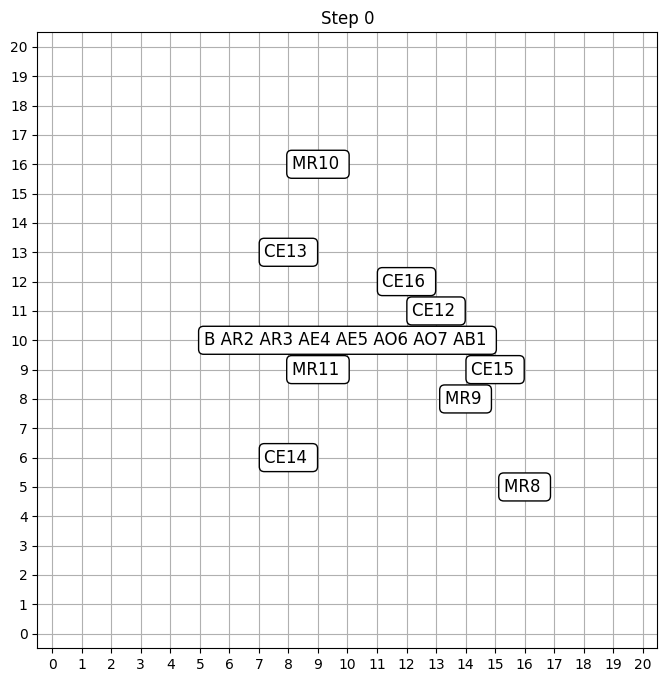

AR2 pegou recurso: Metal Raro11
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (9, 9) is of class ReativoSimples
Agent 3 at position (9, 9) is of class ReativoSimples
Agent 4 at position (11, 11) is of class AgentEstados
Agent 5 at position (9, 10) is of class AgentEstados
Agent 6 at position (9, 9) is of class AgentObjetivo
Agent 7 at position (11, 9) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


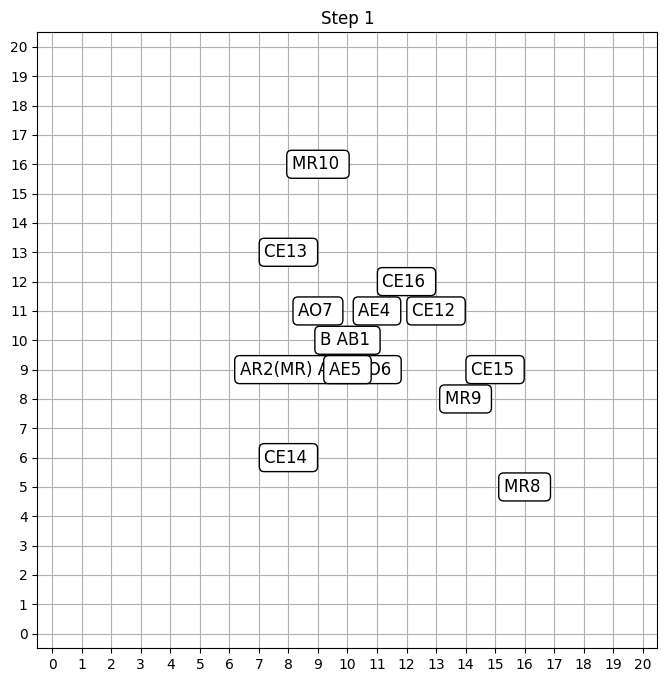

AR2 tem: Metal Raro11
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {13: (13, 8)}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (10, 10) is of class ReativoSimples
Agent 3 at position (8, 9) is of class ReativoSimples
Agent 4 at position (12, 12) is of class AgentEstados
Agent 5 at position (10, 9) is of class AgentEstados
Agent 6 at position (8, 9) is of class AgentObjetivo
Agent 7 at position (12, 8) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


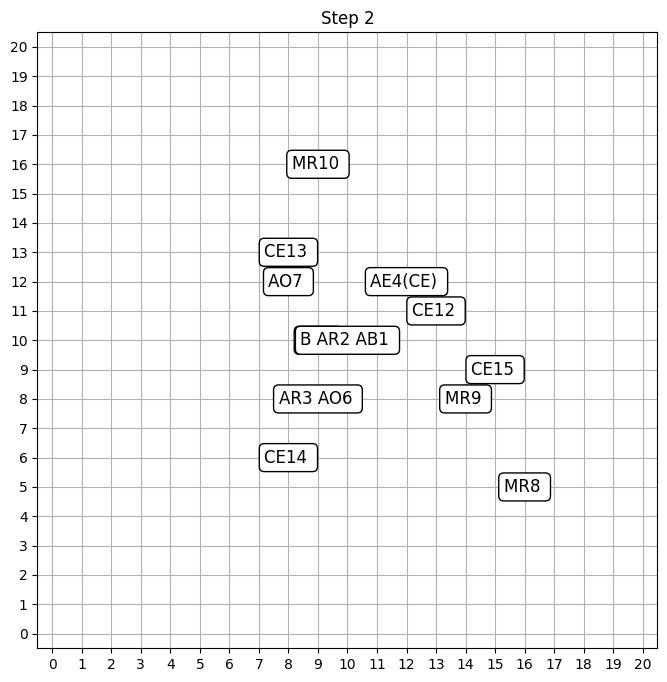

AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
item CE13, na posição (13,8), com distancia 6
item CE14, na posição (6,8), com distancia 3
destino = (6, 8), (6, 8)
AO7 tem o destino: None
AO7 procurando Destino
item CE13, na posição (13,8), com distancia 1
item CE14, na posição (6,8), com distancia 6
destino = (13, 8), (13, 8)
AO7 tem: Cristal Energético13
{'CE': {14: (6, 8)}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (9, 10) is of class ReativoSimples
Agent 3 at position (7, 8) is of class ReativoSimples
Agent 4 at position (13, 13) is of class AgentEstados
Agent 5 at position (11, 9) is of class AgentEstados
Agent 6 at position (7, 8) is of class AgentObjetivo
Agent 7 at position (13, 8) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


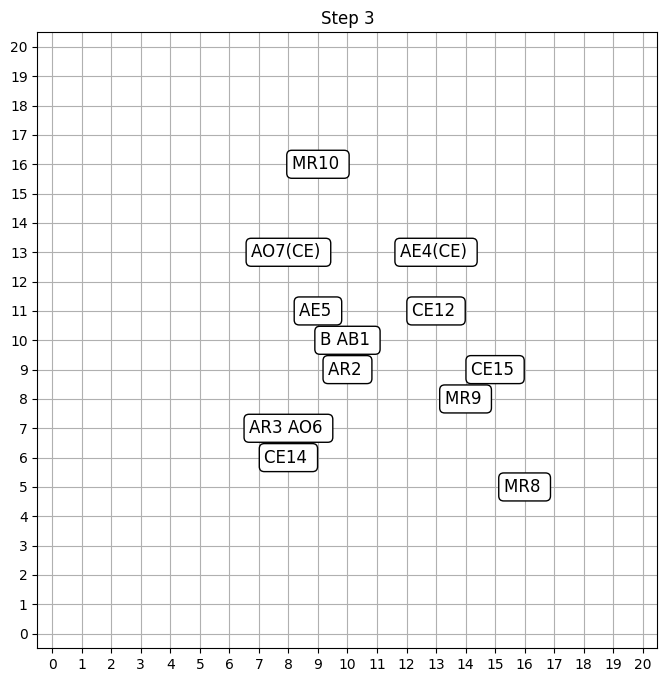

AR3 pegou recurso: Cristal Energético14
AE4 tem: Cristal Energético16
('CE', 14)
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem: Cristal Energético13
AO7 tem o destino: (10, 10)
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (8, 11) is of class ReativoSimples
Agent 3 at position (6, 8) is of class ReativoSimples
Agent 4 at position (14, 13) is of class AgentEstados
Agent 5 at position (10, 8) is of class AgentEstados
Agent 6 at position (7, 9) is of class AgentObjetivo
Agent 7 at position (12, 9) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


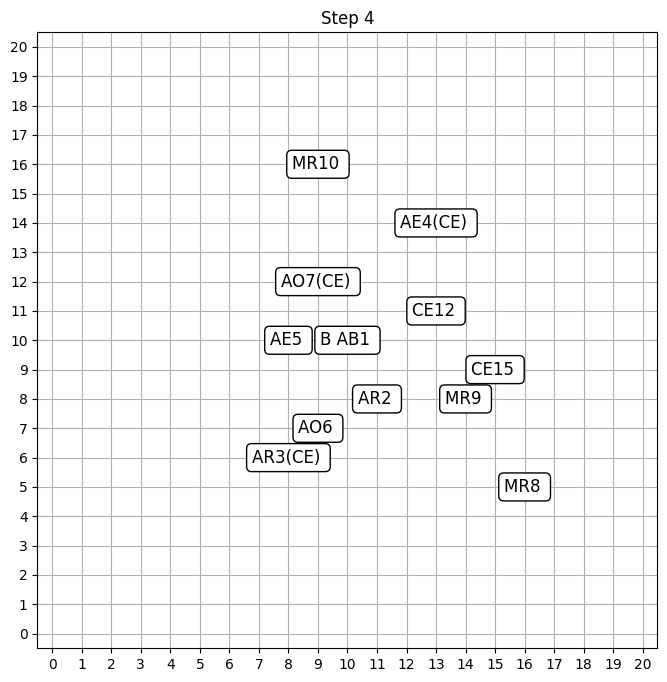

AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem: Cristal Energético13
AO7 tem o destino: (10, 10)
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (8, 12) is of class ReativoSimples
Agent 3 at position (5, 9) is of class ReativoSimples
Agent 4 at position (15, 13) is of class AgentEstados
Agent 5 at position (10, 7) is of class AgentEstados
Agent 6 at position (8, 8) is of class AgentObjetivo
Agent 7 at position (11, 10) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


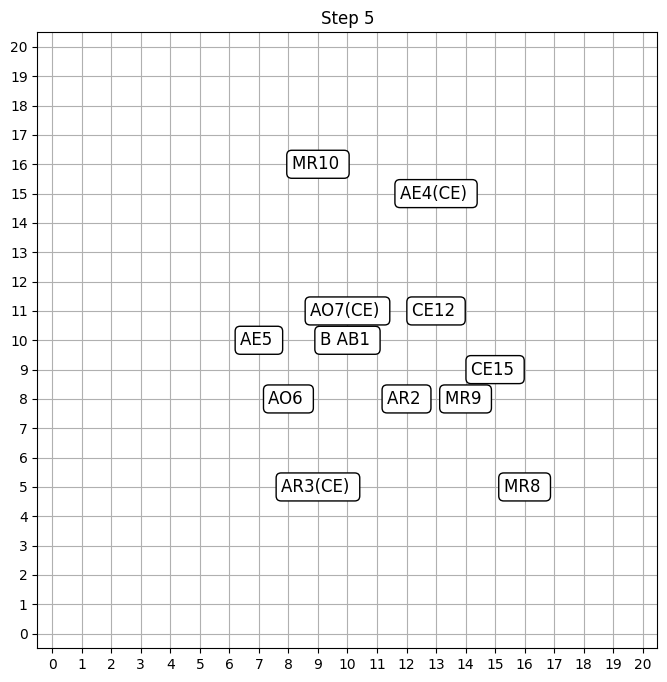

AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
item MR9, na posição (8,14), com distancia 6
destino = (8, 14), (8, 14)
AO7 tem: Cristal Energético13
AO7 tem o destino: (10, 10)
Agente AO7 entrogou o item Cristal Energético!
item MR9, na posição (8,14), com distancia 6
destino = (8, 14), (8, 14)
{'CE': {}, 'MR': {9: (8, 14)}, 'EA': {}, 'I': {}}
Agent 2 at position (7, 13) is of class ReativoSimples
Agent 3 at position (4, 10) is of class ReativoSimples
Agent 4 at position (16, 14) is of class AgentEstados
Agent 5 at position (10, 6) is of class AgentEstados
Agent 6 at position (8, 9) is of class AgentObjetivo
Agent 7 at position (10, 10) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


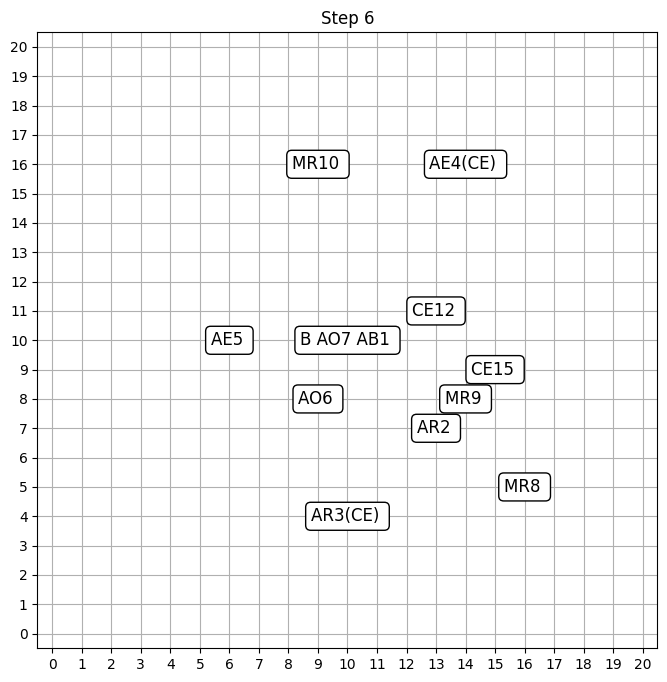

AR2 pegou recurso: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
('MR', 9)
AO6 tem o destino: None
AO6 procurando Destino
item CE15, na posição (9,15), com distancia 7
destino = (9, 15), (9, 15)
('MR', 9)
AO7 tem o destino: None
AO7 procurando Destino
item CE15, na posição (9,15), com distancia 6
destino = (9, 15), (9, 15)
{'CE': {15: (9, 15)}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (8, 14) is of class ReativoSimples
Agent 3 at position (5, 10) is of class ReativoSimples
Agent 4 at position (17, 14) is of class AgentEstados
Agent 5 at position (9, 7) is of class AgentEstados
Agent 6 at position (9, 10) is of class AgentObjetivo
Agent 7 at position (9, 11) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


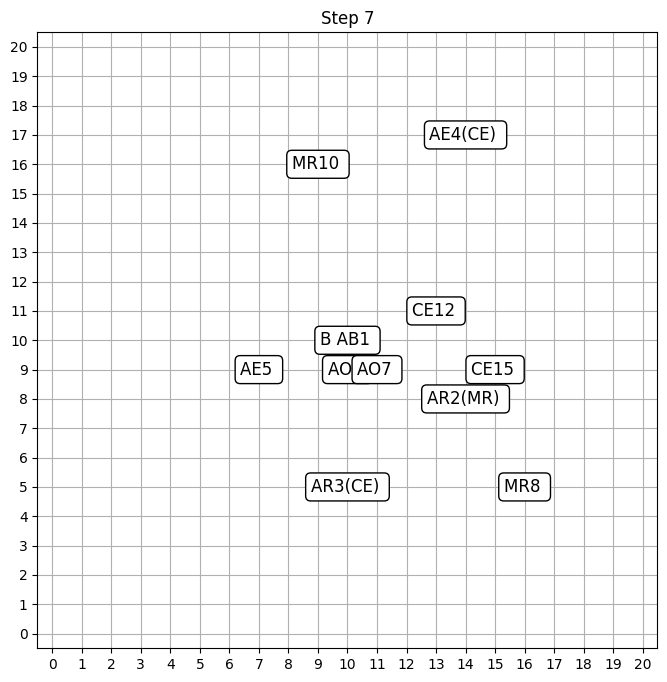

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
('CE', 15)
AO6 tem o destino: (9, 15)
('CE', 15)
AO7 tem o destino: (9, 15)
{'CE': {15: (9, 15)}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (7, 14) is of class ReativoSimples
Agent 3 at position (4, 10) is of class ReativoSimples
Agent 4 at position (18, 13) is of class AgentEstados
Agent 5 at position (8, 8) is of class AgentEstados
Agent 6 at position (9, 11) is of class AgentObjetivo
Agent 7 at position (9, 12) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


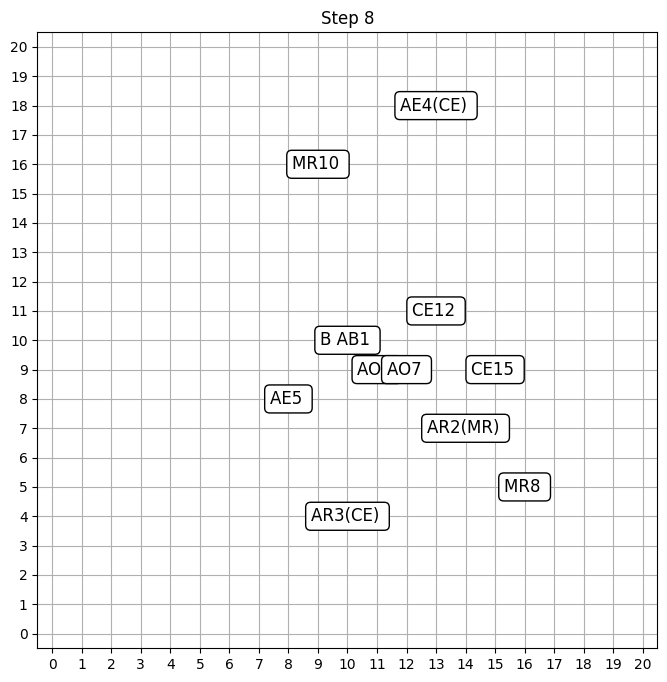

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
('CE', 15)
AO6 tem o destino: (9, 15)
('CE', 15)
AO7 tem o destino: (9, 15)
{'CE': {15: (9, 15)}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (7, 13) is of class ReativoSimples
Agent 3 at position (5, 10) is of class ReativoSimples
Agent 4 at position (17, 13) is of class AgentEstados
Agent 5 at position (9, 8) is of class AgentEstados
Agent 6 at position (9, 12) is of class AgentObjetivo
Agent 7 at position (9, 13) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


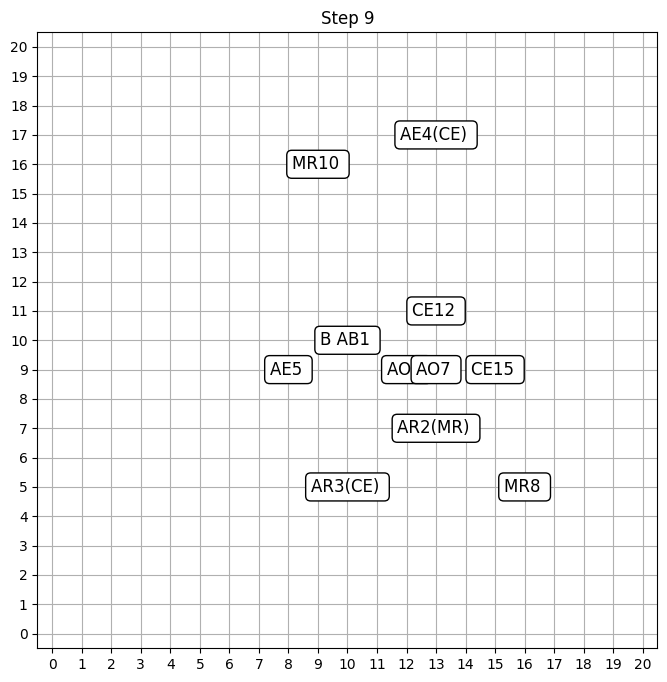

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
('CE', 15)
AO6 tem o destino: (9, 15)
('CE', 15)
AO7 tem o destino: (9, 15)
{'CE': {15: (9, 15)}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (7, 14) is of class ReativoSimples
Agent 3 at position (6, 11) is of class ReativoSimples
Agent 4 at position (18, 14) is of class AgentEstados
Agent 5 at position (8, 9) is of class AgentEstados
Agent 6 at position (9, 13) is of class AgentObjetivo
Agent 7 at position (9, 14) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


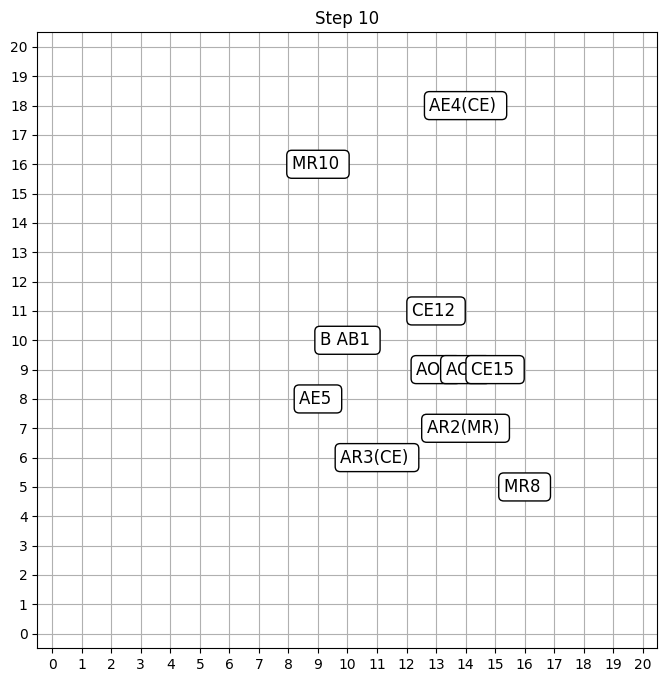

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
('CE', 15)
AO6 tem o destino: (9, 15)
('CE', 15)
AO7 tem o destino: (9, 15)
AO7 tem: Cristal Energético15
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (6, 14) is of class ReativoSimples
Agent 3 at position (7, 10) is of class ReativoSimples
Agent 4 at position (18, 15) is of class AgentEstados
Agent 5 at position (7, 9) is of class AgentEstados
Agent 6 at position (9, 14) is of class AgentObjetivo
Agent 7 at position (9, 15) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


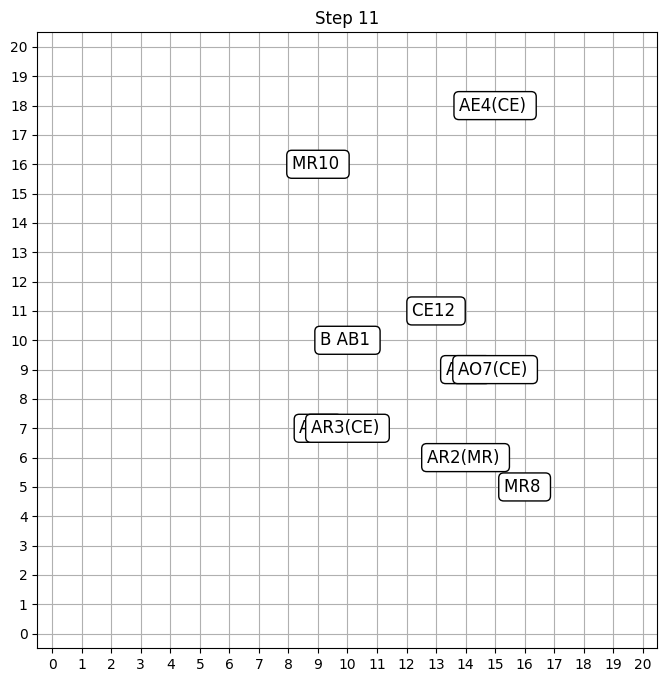

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
('CE', 15)
AO6 tem o destino: None
AO6 procurando Destino
item MR8, na posição (5,16), com distancia 6
destino = (5, 16), (5, 16)
AO7 tem: Cristal Energético15
AO7 tem o destino: (10, 10)
{'CE': {12: (11, 13)}, 'MR': {8: (5, 16)}, 'EA': {}, 'I': {}}
Agent 2 at position (6, 15) is of class ReativoSimples
Agent 3 at position (8, 11) is of class ReativoSimples
Agent 4 at position (17, 16) is of class AgentEstados
Agent 5 at position (6, 8) is of class AgentEstados
Agent 6 at position (8, 15) is of class AgentObjetivo
Agent 7 at position (10, 14) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


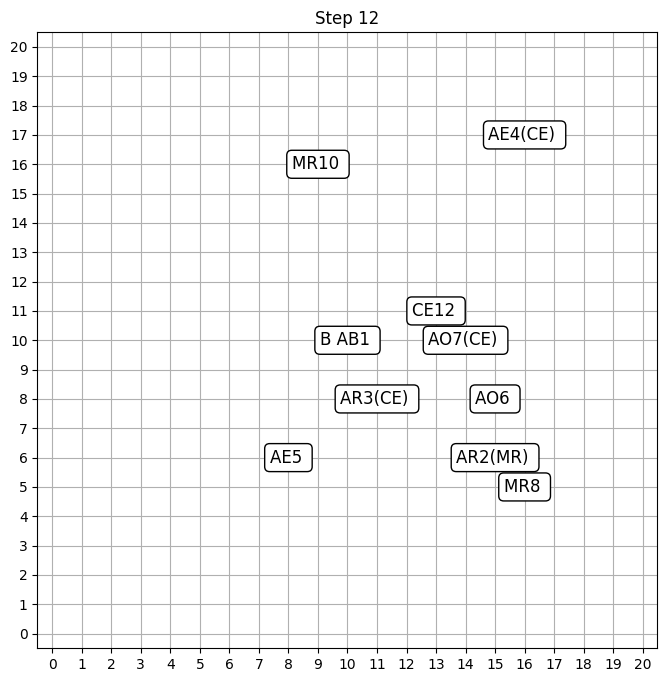

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
('MR', 8)
AO6 tem o destino: (5, 16)
AO7 tem: Cristal Energético15
AO7 tem o destino: (10, 10)
{'CE': {12: (11, 13)}, 'MR': {8: (5, 16)}, 'EA': {}, 'I': {}}
Agent 2 at position (5, 14) is of class ReativoSimples
Agent 3 at position (7, 12) is of class ReativoSimples
Agent 4 at position (18, 17) is of class AgentEstados
Agent 5 at position (6, 7) is of class AgentEstados
Agent 6 at position (7, 16) is of class AgentObjetivo
Agent 7 at position (10, 13) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


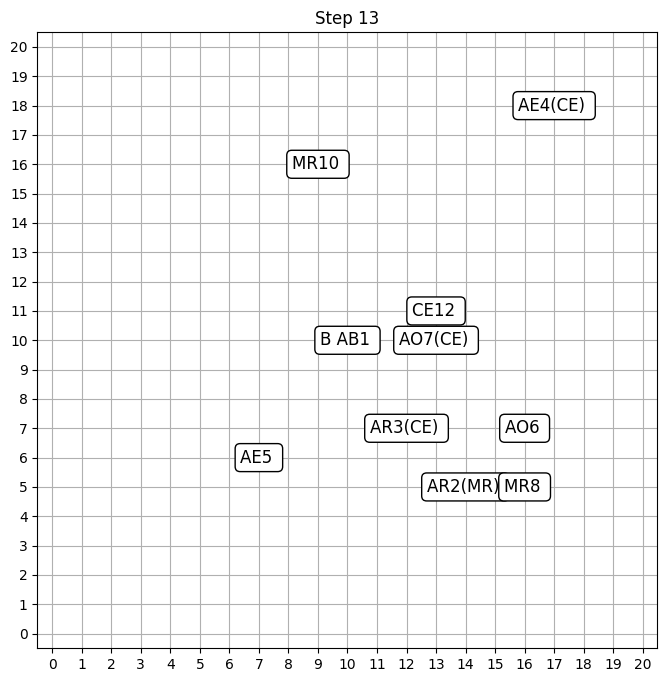

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
('MR', 8)
AO6 tem o destino: (5, 16)
AO7 tem: Cristal Energético15
AO7 tem o destino: (10, 10)
{'CE': {12: (11, 13)}, 'MR': {8: (5, 16)}, 'EA': {}, 'I': {}}
Agent 2 at position (4, 14) is of class ReativoSimples
Agent 3 at position (8, 13) is of class ReativoSimples
Agent 4 at position (17, 18) is of class AgentEstados
Agent 5 at position (7, 8) is of class AgentEstados
Agent 6 at position (6, 16) is of class AgentObjetivo
Agent 7 at position (10, 12) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


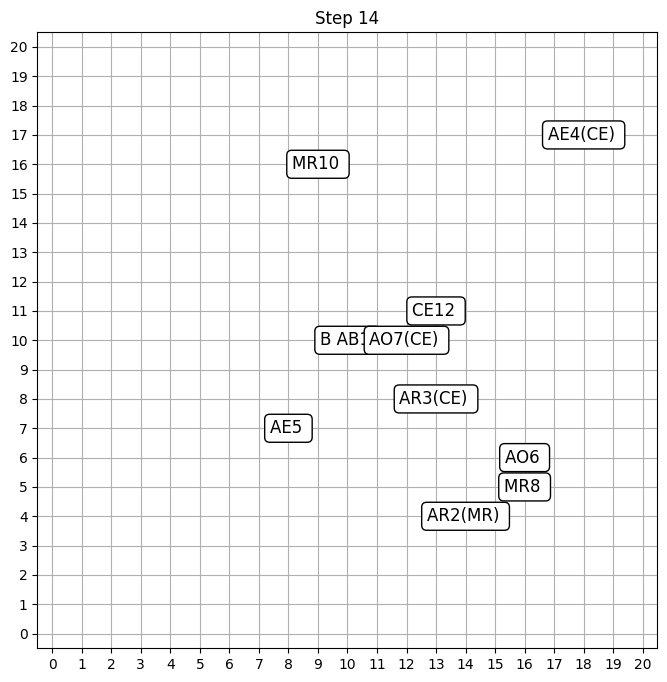

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
('MR', 8)
AO6 tem o destino: (5, 16)
AO6 tem: Metal Raro8
AO7 tem: Cristal Energético15
AO7 tem o destino: (10, 10)
{'CE': {12: (11, 13)}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (3, 13) is of class ReativoSimples
Agent 3 at position (7, 12) is of class ReativoSimples
Agent 4 at position (16, 19) is of class AgentEstados
Agent 5 at position (6, 9) is of class AgentEstados
Agent 6 at position (5, 16) is of class AgentObjetivo
Agent 7 at position (10, 11) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


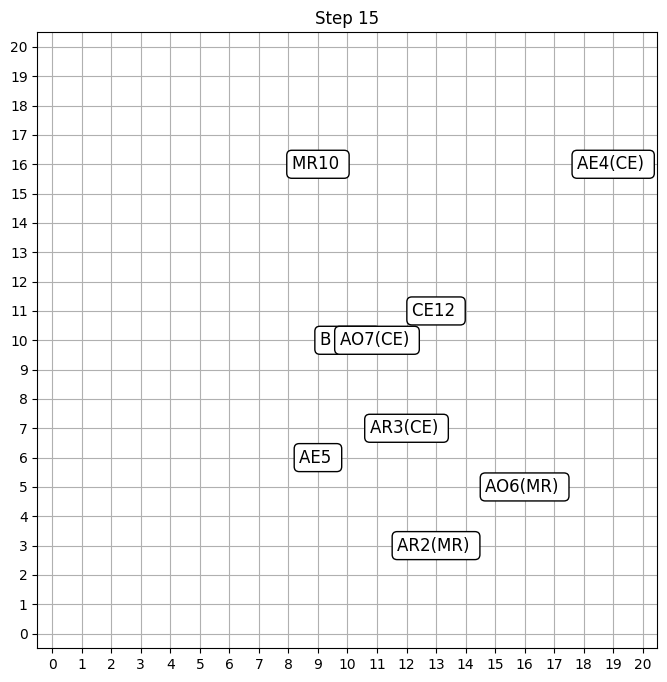

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem: Metal Raro8
AO6 tem o destino: (10, 10)
AO7 tem: Cristal Energético15
AO7 tem o destino: (10, 10)
Agente AO7 entrogou o item Cristal Energético!
item CE12, na posição (11,13), com distancia 4
destino = (11, 13), (11, 13)
{'CE': {12: (11, 13)}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (3, 14) is of class ReativoSimples
Agent 3 at position (6, 13) is of class ReativoSimples
Agent 4 at position (16, 20) is of class AgentEstados
Agent 5 at position (7, 10) is of class AgentEstados
Agent 6 at position (6, 15) is of class AgentObjetivo
Agent 7 at position (10, 10) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


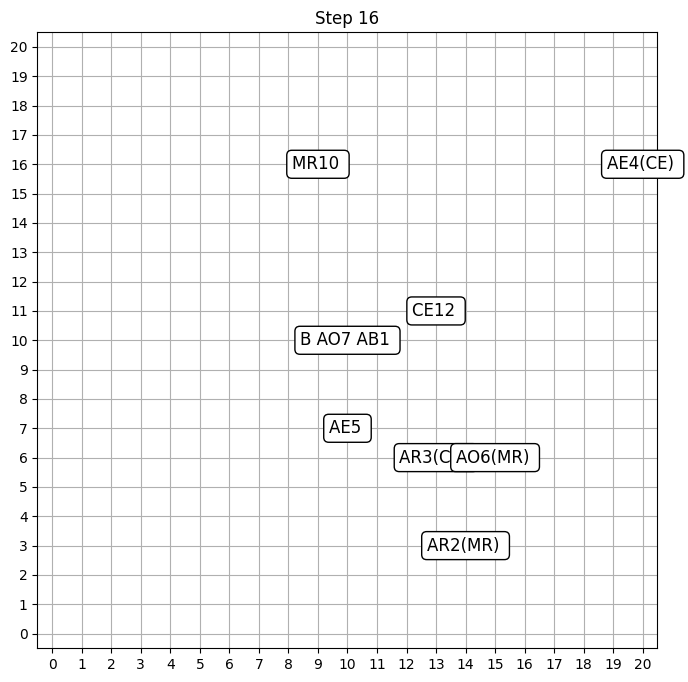

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem: Metal Raro8
AO6 tem o destino: (10, 10)
('CE', 12)
AO7 tem o destino: None
AO7 procurando Destino
item CE12, na posição (11,13), com distancia 4
destino = (11, 13), (11, 13)
{'CE': {12: (11, 13)}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (4, 14) is of class ReativoSimples
Agent 3 at position (6, 12) is of class ReativoSimples
Agent 4 at position (15, 20) is of class AgentEstados
Agent 5 at position (6, 11) is of class AgentEstados
Agent 6 at position (7, 14) is of class AgentObjetivo
Agent 7 at position (11, 11) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


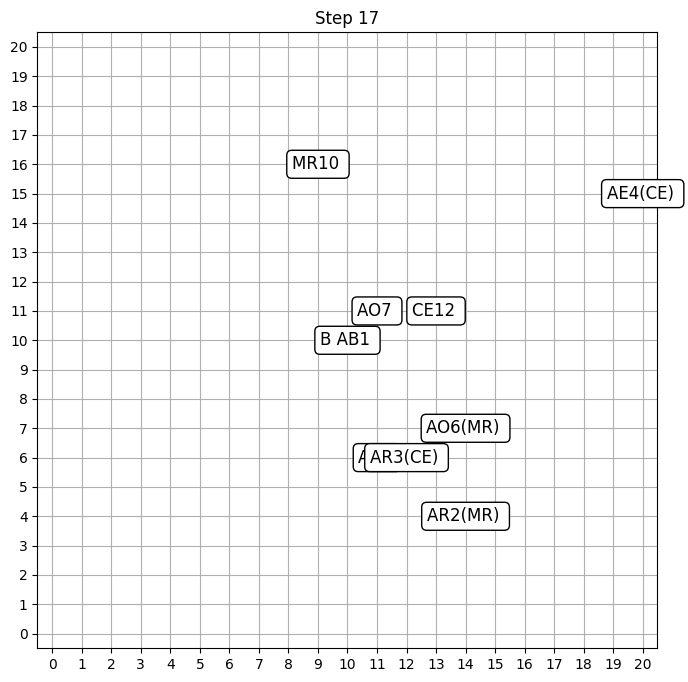

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem: Metal Raro8
AO6 tem o destino: (10, 10)
('CE', 12)
AO7 tem o destino: (11, 13)
{'CE': {12: (11, 13)}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (3, 14) is of class ReativoSimples
Agent 3 at position (7, 13) is of class ReativoSimples
Agent 4 at position (14, 19) is of class AgentEstados
Agent 5 at position (5, 12) is of class AgentEstados
Agent 6 at position (8, 13) is of class AgentObjetivo
Agent 7 at position (11, 12) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


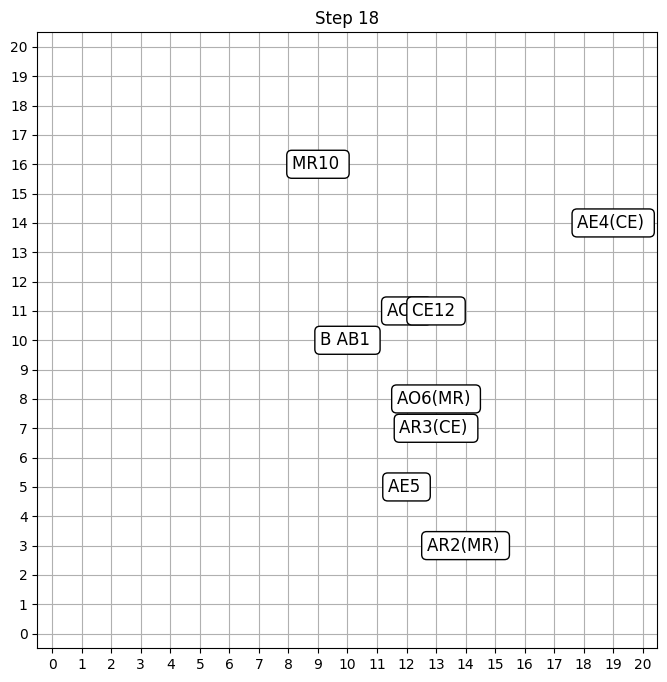

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem: Metal Raro8
AO6 tem o destino: (10, 10)
('CE', 12)
AO7 tem o destino: (11, 13)
AO7 tem: Cristal Energético12
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (3, 15) is of class ReativoSimples
Agent 3 at position (6, 12) is of class ReativoSimples
Agent 4 at position (14, 20) is of class AgentEstados
Agent 5 at position (6, 12) is of class AgentEstados
Agent 6 at position (9, 12) is of class AgentObjetivo
Agent 7 at position (11, 13) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


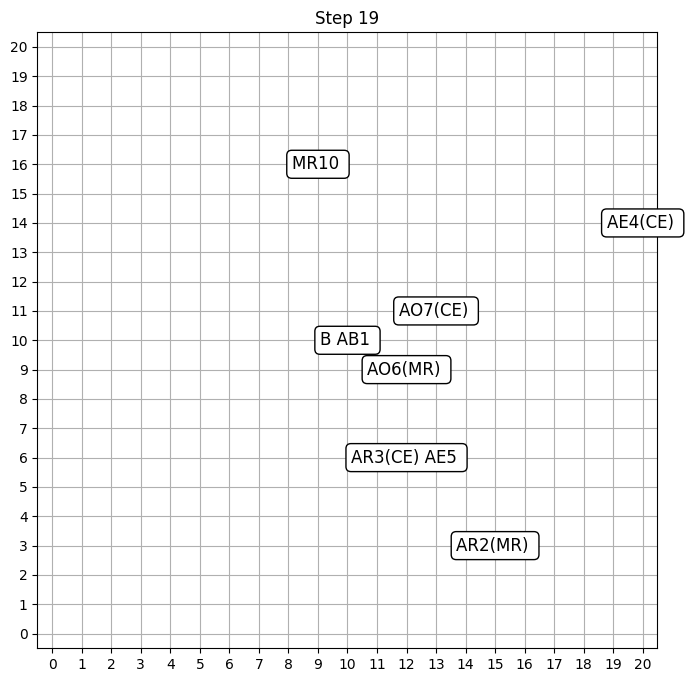

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem: Metal Raro8
AO6 tem o destino: (10, 10)
AO7 tem: Cristal Energético12
AO7 tem o destino: (10, 10)
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (2, 16) is of class ReativoSimples
Agent 3 at position (7, 12) is of class ReativoSimples
Agent 4 at position (15, 19) is of class AgentEstados
Agent 5 at position (5, 13) is of class AgentEstados
Agent 6 at position (10, 11) is of class AgentObjetivo
Agent 7 at position (10, 12) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


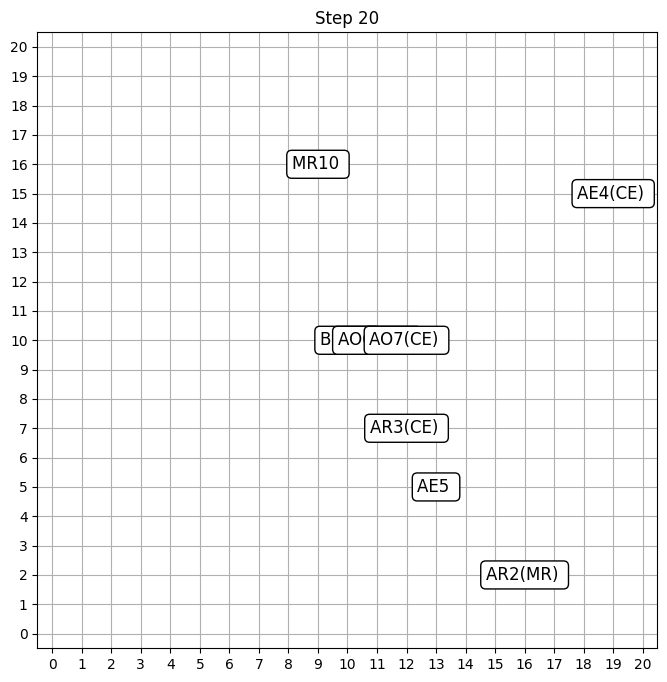

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem: Metal Raro8
AO6 tem o destino: (10, 10)
Agente AO6 entrogou o item Metal Raro!
destino = None, None
AO7 tem: Cristal Energético12
AO7 tem o destino: (10, 10)
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (3, 17) is of class ReativoSimples
Agent 3 at position (6, 11) is of class ReativoSimples
Agent 4 at position (14, 18) is of class AgentEstados
Agent 5 at position (4, 13) is of class AgentEstados
Agent 6 at position (10, 10) is of class AgentObjetivo
Agent 7 at position (10, 11) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


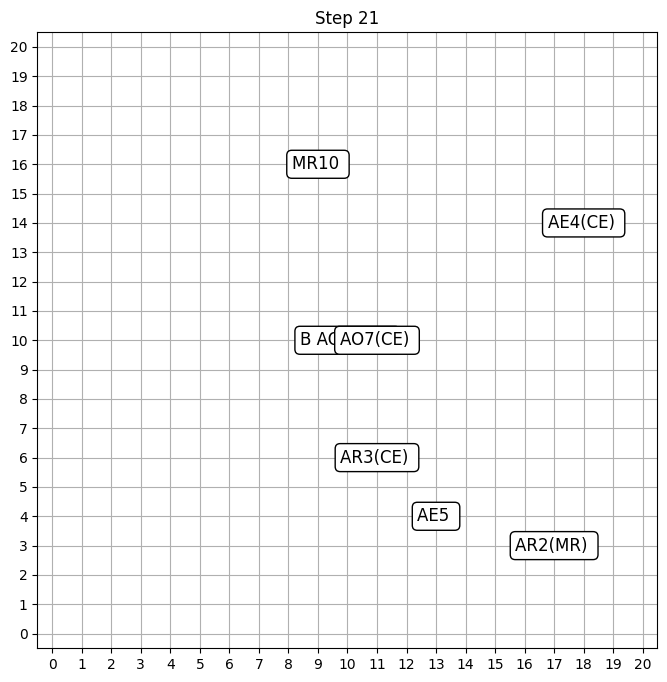

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem: Cristal Energético12
AO7 tem o destino: (10, 10)
Agente AO7 entrogou o item Cristal Energético!
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (3, 16) is of class ReativoSimples
Agent 3 at position (6, 10) is of class ReativoSimples
Agent 4 at position (13, 18) is of class AgentEstados
Agent 5 at position (4, 12) is of class AgentEstados
Agent 6 at position (9, 10) is of class AgentObjetivo
Agent 7 at position (10, 10) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


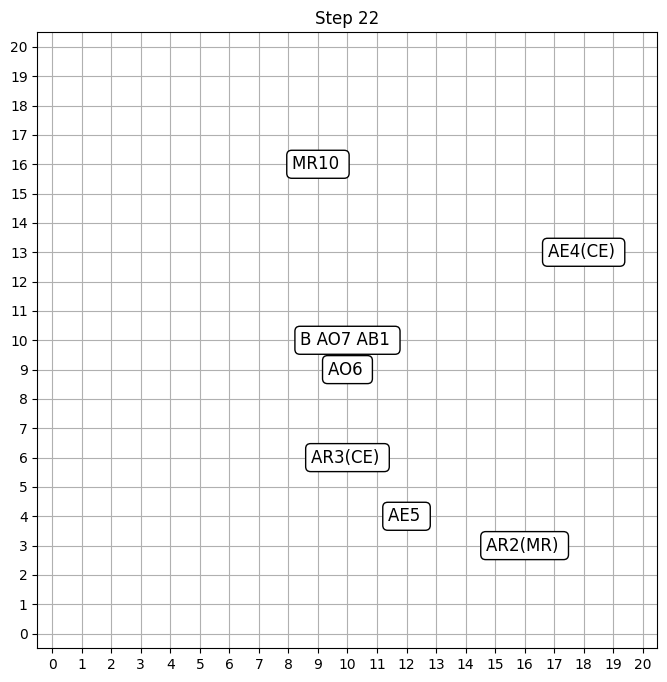

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (4, 16) is of class ReativoSimples
Agent 3 at position (7, 11) is of class ReativoSimples
Agent 4 at position (13, 19) is of class AgentEstados
Agent 5 at position (3, 13) is of class AgentEstados
Agent 6 at position (8, 10) is of class AgentObjetivo
Agent 7 at position (10, 9) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


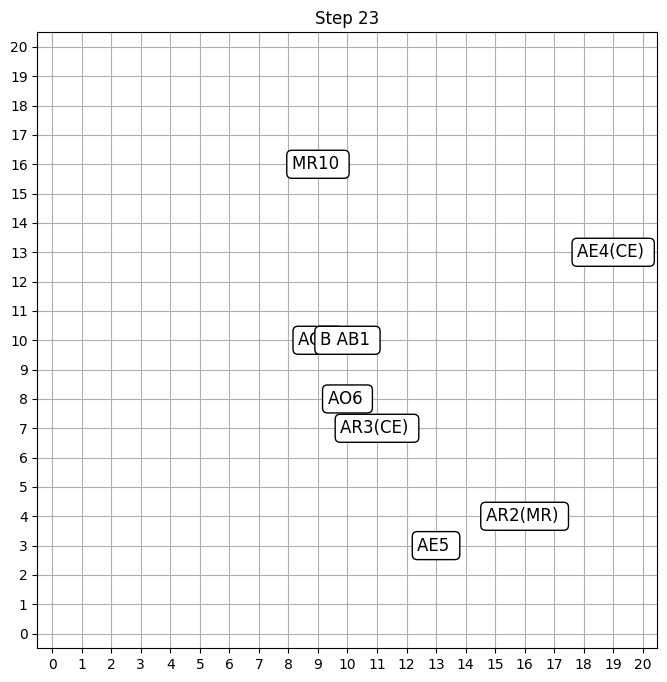

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (4, 17) is of class ReativoSimples
Agent 3 at position (8, 10) is of class ReativoSimples
Agent 4 at position (12, 20) is of class AgentEstados
Agent 5 at position (3, 12) is of class AgentEstados
Agent 6 at position (7, 10) is of class AgentObjetivo
Agent 7 at position (10, 8) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


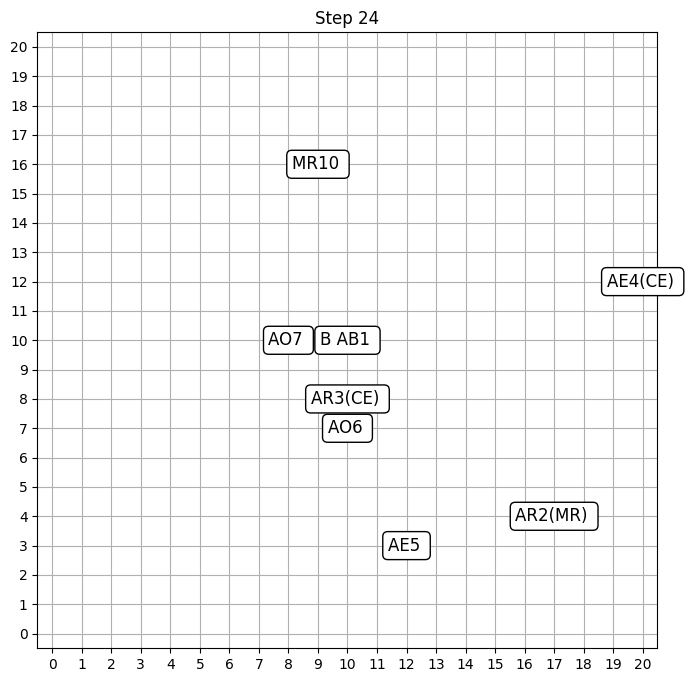

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (5, 18) is of class ReativoSimples
Agent 3 at position (8, 9) is of class ReativoSimples
Agent 4 at position (13, 20) is of class AgentEstados
Agent 5 at position (3, 11) is of class AgentEstados
Agent 6 at position (7, 11) is of class AgentObjetivo
Agent 7 at position (10, 7) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


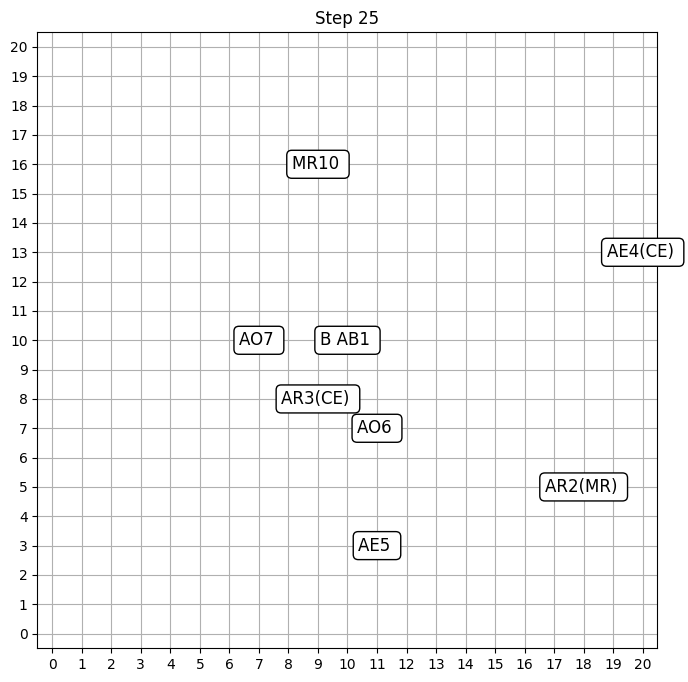

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (4, 17) is of class ReativoSimples
Agent 3 at position (7, 10) is of class ReativoSimples
Agent 4 at position (12, 19) is of class AgentEstados
Agent 5 at position (2, 10) is of class AgentEstados
Agent 6 at position (8, 12) is of class AgentObjetivo
Agent 7 at position (9, 8) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


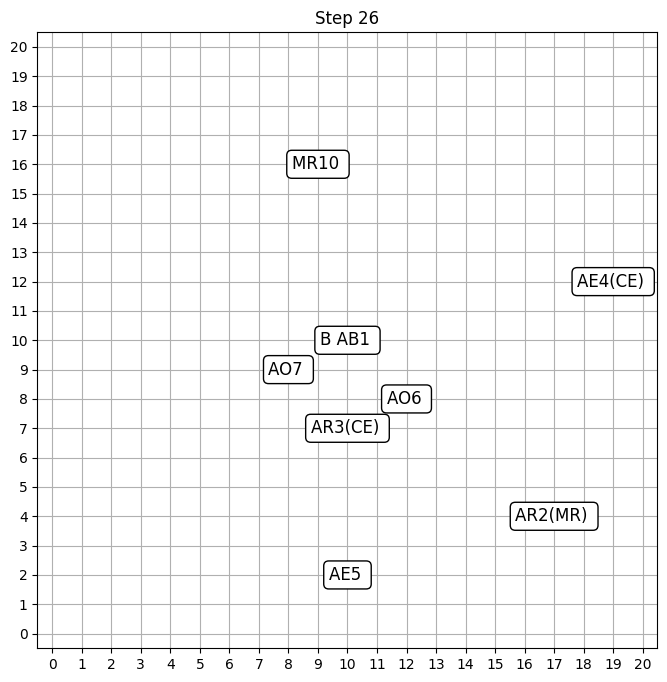

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (3, 16) is of class ReativoSimples
Agent 3 at position (8, 10) is of class ReativoSimples
Agent 4 at position (11, 19) is of class AgentEstados
Agent 5 at position (3, 10) is of class AgentEstados
Agent 6 at position (9, 13) is of class AgentObjetivo
Agent 7 at position (8, 7) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


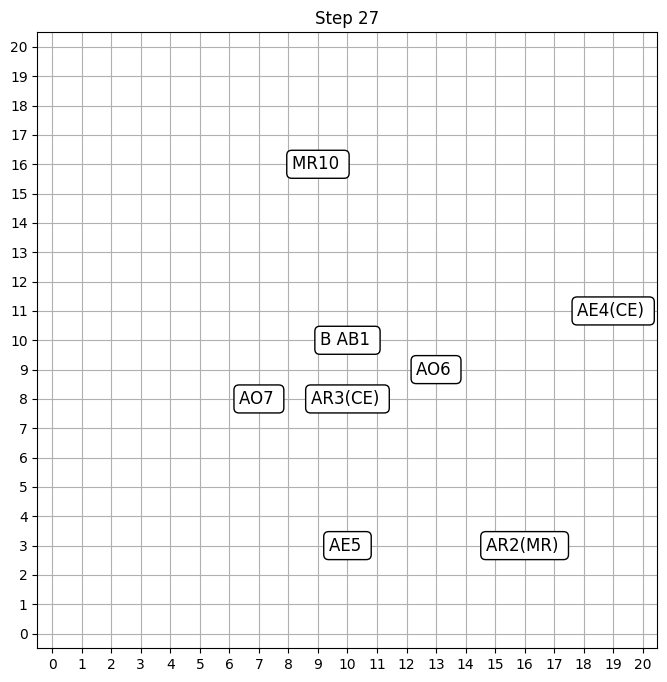

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (4, 15) is of class ReativoSimples
Agent 3 at position (7, 10) is of class ReativoSimples
Agent 4 at position (10, 18) is of class AgentEstados
Agent 5 at position (2, 11) is of class AgentEstados
Agent 6 at position (10, 14) is of class AgentObjetivo
Agent 7 at position (9, 7) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


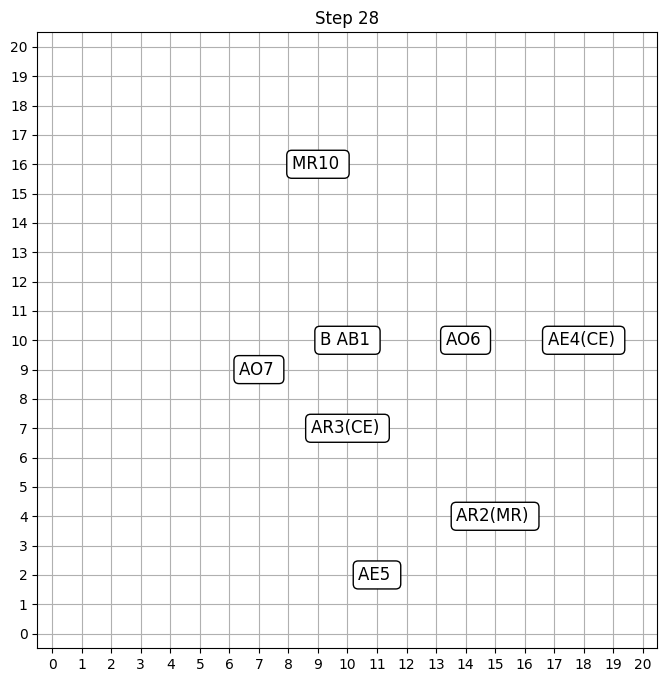

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (3, 16) is of class ReativoSimples
Agent 3 at position (6, 10) is of class ReativoSimples
Agent 4 at position (11, 17) is of class AgentEstados
Agent 5 at position (1, 11) is of class AgentEstados
Agent 6 at position (9, 15) is of class AgentObjetivo
Agent 7 at position (8, 8) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


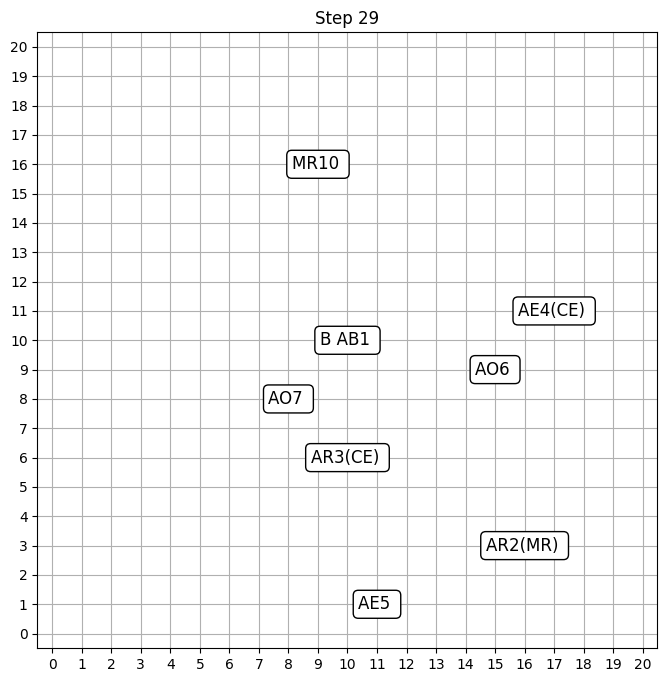

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (4, 16) is of class ReativoSimples
Agent 3 at position (6, 11) is of class ReativoSimples
Agent 4 at position (12, 16) is of class AgentEstados
Agent 5 at position (2, 12) is of class AgentEstados
Agent 6 at position (10, 16) is of class AgentObjetivo
Agent 7 at position (7, 9) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


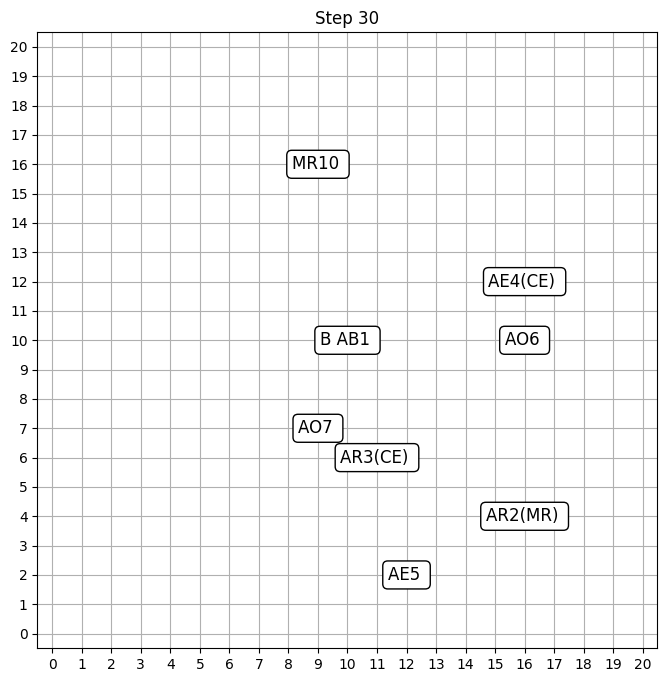

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (5, 15) is of class ReativoSimples
Agent 3 at position (7, 11) is of class ReativoSimples
Agent 4 at position (12, 17) is of class AgentEstados
Agent 5 at position (1, 12) is of class AgentEstados
Agent 6 at position (9, 17) is of class AgentObjetivo
Agent 7 at position (7, 10) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


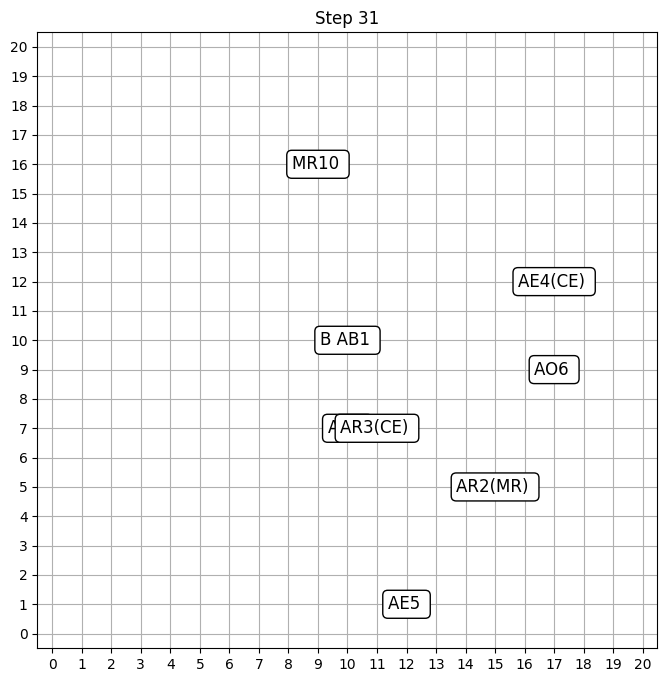

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (4, 16) is of class ReativoSimples
Agent 3 at position (6, 11) is of class ReativoSimples
Agent 4 at position (13, 17) is of class AgentEstados
Agent 5 at position (1, 13) is of class AgentEstados
Agent 6 at position (8, 18) is of class AgentObjetivo
Agent 7 at position (6, 11) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


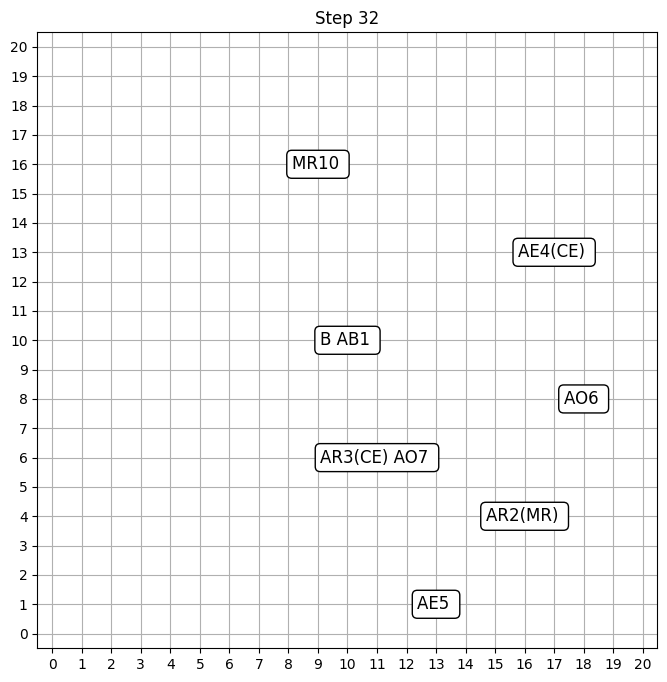

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (5, 17) is of class ReativoSimples
Agent 3 at position (5, 11) is of class ReativoSimples
Agent 4 at position (14, 17) is of class AgentEstados
Agent 5 at position (0, 12) is of class AgentEstados
Agent 6 at position (8, 19) is of class AgentObjetivo
Agent 7 at position (5, 11) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


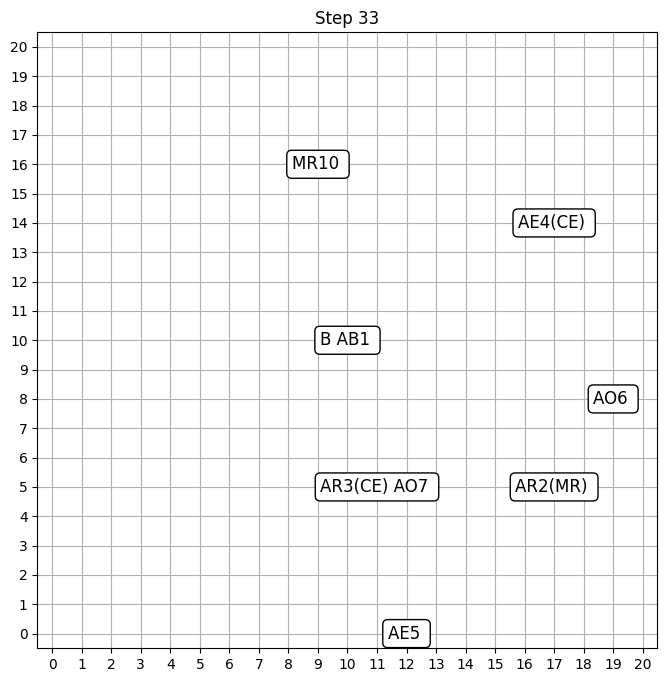

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (4, 18) is of class ReativoSimples
Agent 3 at position (5, 12) is of class ReativoSimples
Agent 4 at position (13, 16) is of class AgentEstados
Agent 5 at position (0, 13) is of class AgentEstados
Agent 6 at position (9, 19) is of class AgentObjetivo
Agent 7 at position (6, 10) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


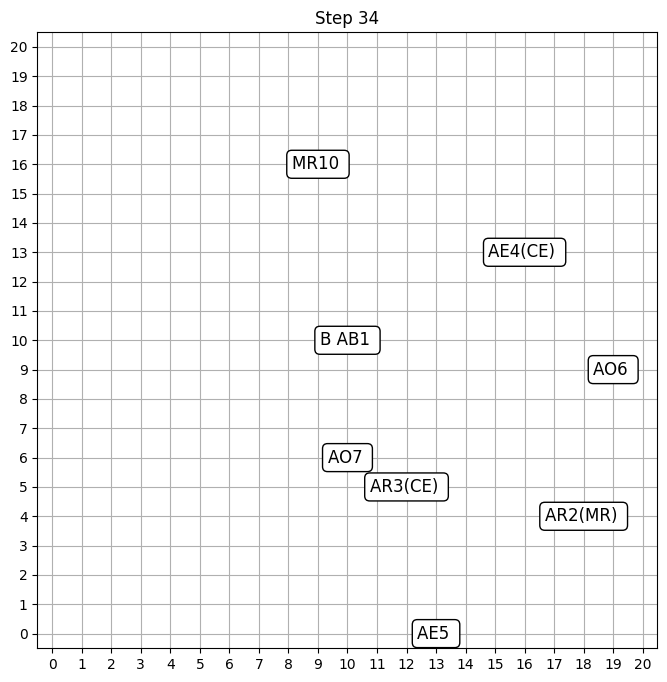

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (3, 18) is of class ReativoSimples
Agent 3 at position (4, 11) is of class ReativoSimples
Agent 4 at position (14, 15) is of class AgentEstados
Agent 5 at position (1, 14) is of class AgentEstados
Agent 6 at position (10, 18) is of class AgentObjetivo
Agent 7 at position (6, 9) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


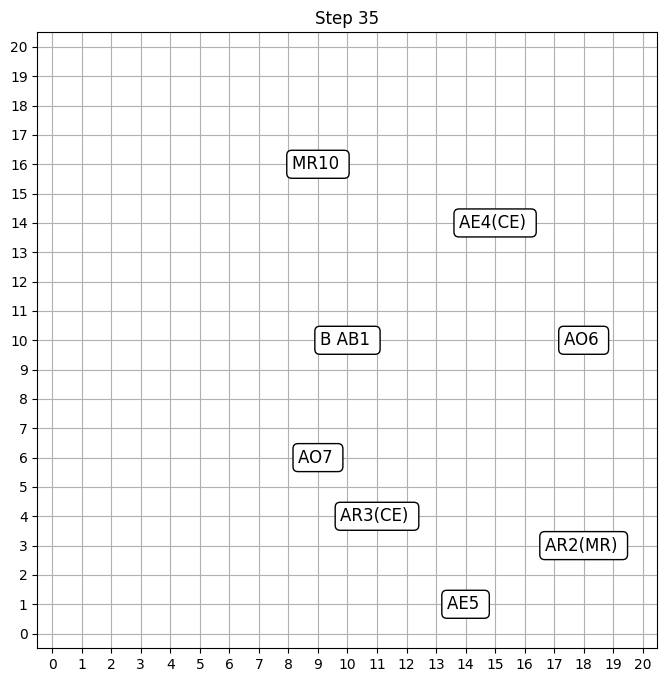

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (2, 17) is of class ReativoSimples
Agent 3 at position (4, 12) is of class ReativoSimples
Agent 4 at position (14, 16) is of class AgentEstados
Agent 5 at position (1, 15) is of class AgentEstados
Agent 6 at position (11, 17) is of class AgentObjetivo
Agent 7 at position (5, 9) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


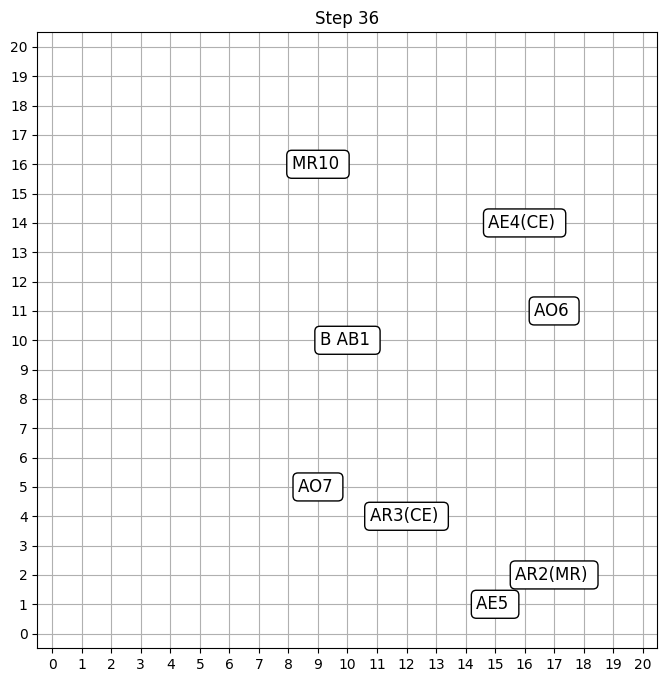

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (1, 18) is of class ReativoSimples
Agent 3 at position (3, 13) is of class ReativoSimples
Agent 4 at position (15, 17) is of class AgentEstados
Agent 5 at position (1, 16) is of class AgentEstados
Agent 6 at position (11, 16) is of class AgentObjetivo
Agent 7 at position (5, 8) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


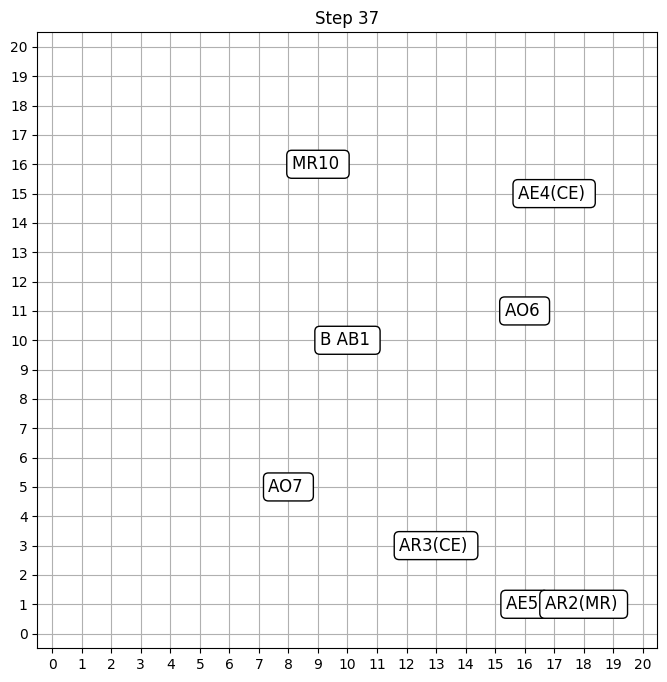

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (2, 19) is of class ReativoSimples
Agent 3 at position (2, 14) is of class ReativoSimples
Agent 4 at position (15, 16) is of class AgentEstados
Agent 5 at position (2, 17) is of class AgentEstados
Agent 6 at position (12, 17) is of class AgentObjetivo
Agent 7 at position (5, 7) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


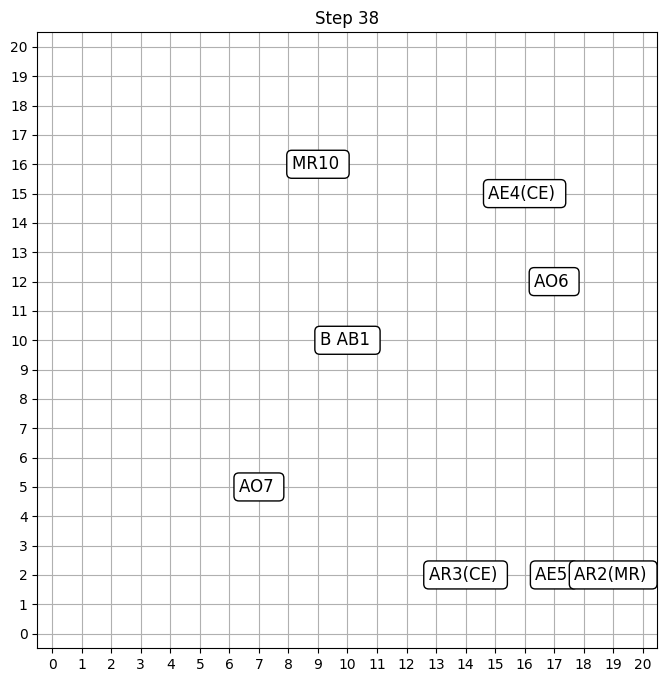

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (3, 19) is of class ReativoSimples
Agent 3 at position (2, 13) is of class ReativoSimples
Agent 4 at position (16, 17) is of class AgentEstados
Agent 5 at position (3, 17) is of class AgentEstados
Agent 6 at position (13, 17) is of class AgentObjetivo
Agent 7 at position (4, 7) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


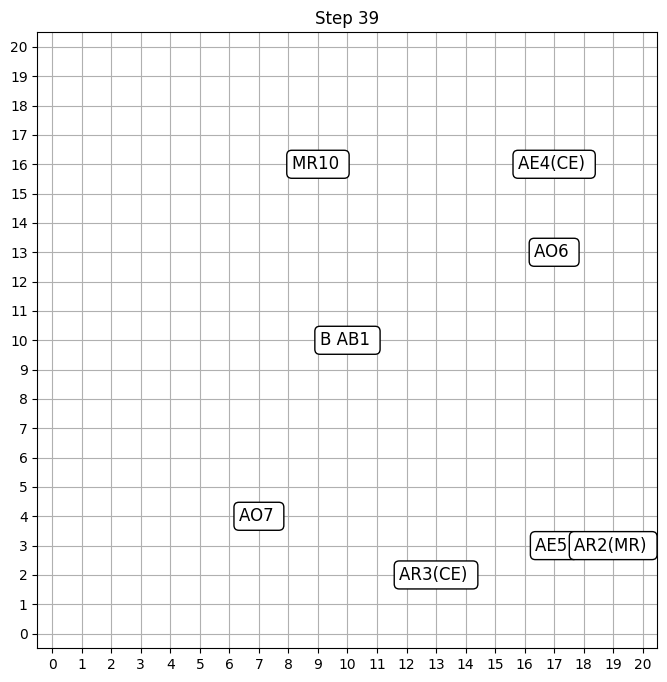

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (3, 18) is of class ReativoSimples
Agent 3 at position (1, 14) is of class ReativoSimples
Agent 4 at position (15, 18) is of class AgentEstados
Agent 5 at position (3, 18) is of class AgentEstados
Agent 6 at position (14, 16) is of class AgentObjetivo
Agent 7 at position (4, 6) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


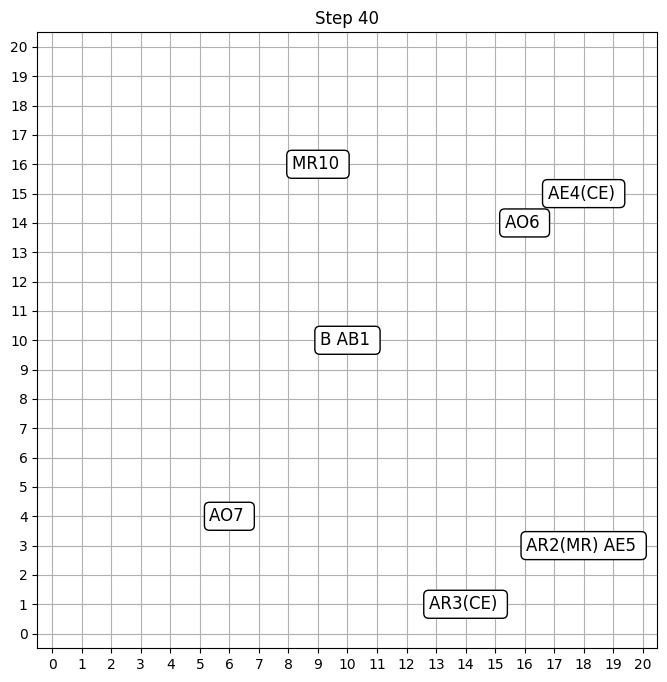

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (4, 18) is of class ReativoSimples
Agent 3 at position (0, 15) is of class ReativoSimples
Agent 4 at position (16, 18) is of class AgentEstados
Agent 5 at position (3, 19) is of class AgentEstados
Agent 6 at position (13, 15) is of class AgentObjetivo
Agent 7 at position (5, 6) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


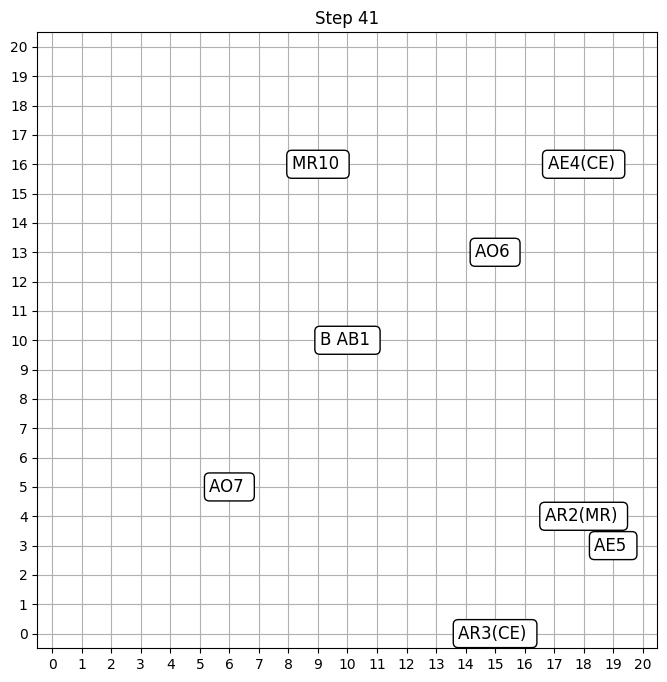

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (5, 17) is of class ReativoSimples
Agent 3 at position (1, 16) is of class ReativoSimples
Agent 4 at position (17, 17) is of class AgentEstados
Agent 5 at position (2, 20) is of class AgentEstados
Agent 6 at position (12, 14) is of class AgentObjetivo
Agent 7 at position (6, 6) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


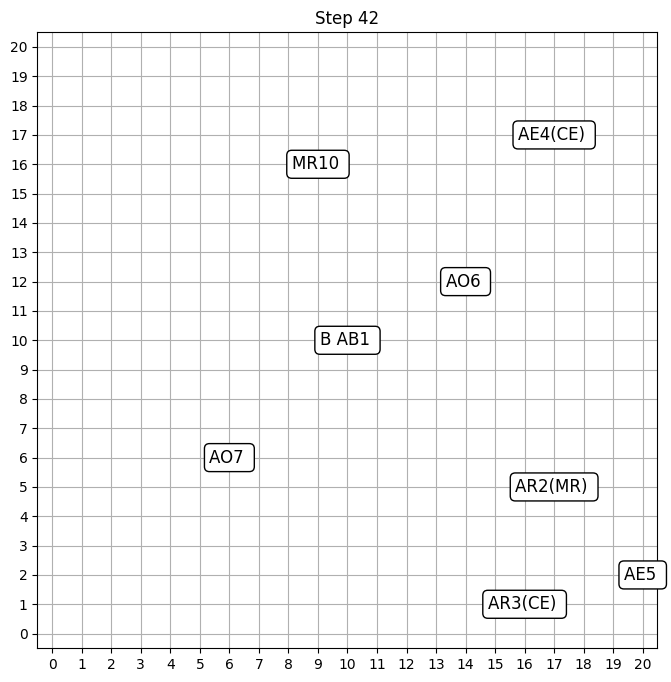

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (5, 18) is of class ReativoSimples
Agent 3 at position (2, 16) is of class ReativoSimples
Agent 4 at position (18, 16) is of class AgentEstados
Agent 5 at position (2, 19) is of class AgentEstados
Agent 6 at position (11, 15) is of class AgentObjetivo
Agent 7 at position (7, 7) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


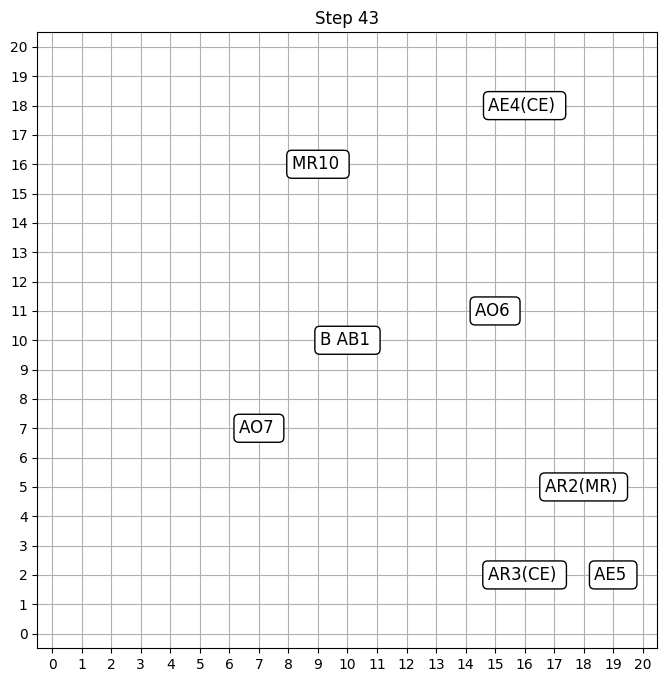

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (5, 19) is of class ReativoSimples
Agent 3 at position (1, 17) is of class ReativoSimples
Agent 4 at position (17, 15) is of class AgentEstados
Agent 5 at position (1, 19) is of class AgentEstados
Agent 6 at position (10, 15) is of class AgentObjetivo
Agent 7 at position (7, 8) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


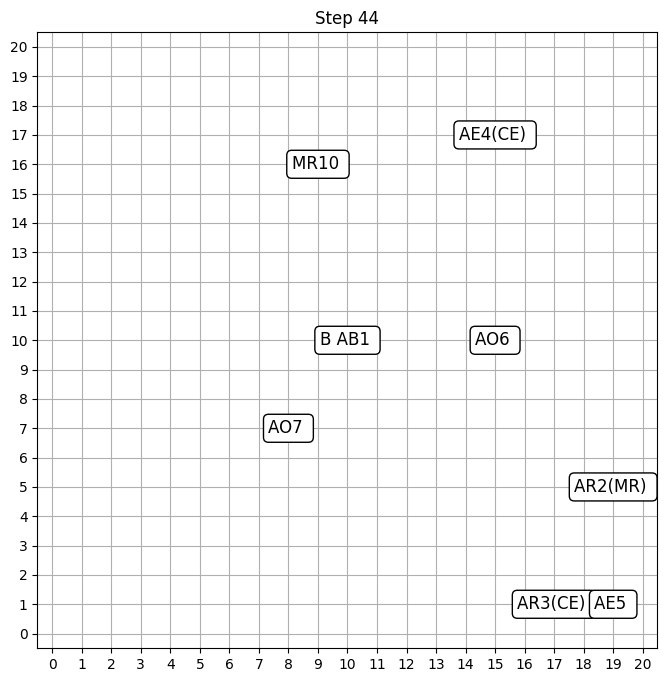

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (5, 20) is of class ReativoSimples
Agent 3 at position (2, 18) is of class ReativoSimples
Agent 4 at position (16, 16) is of class AgentEstados
Agent 5 at position (0, 20) is of class AgentEstados
Agent 6 at position (9, 16) is of class AgentObjetivo
Agent 7 at position (8, 9) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


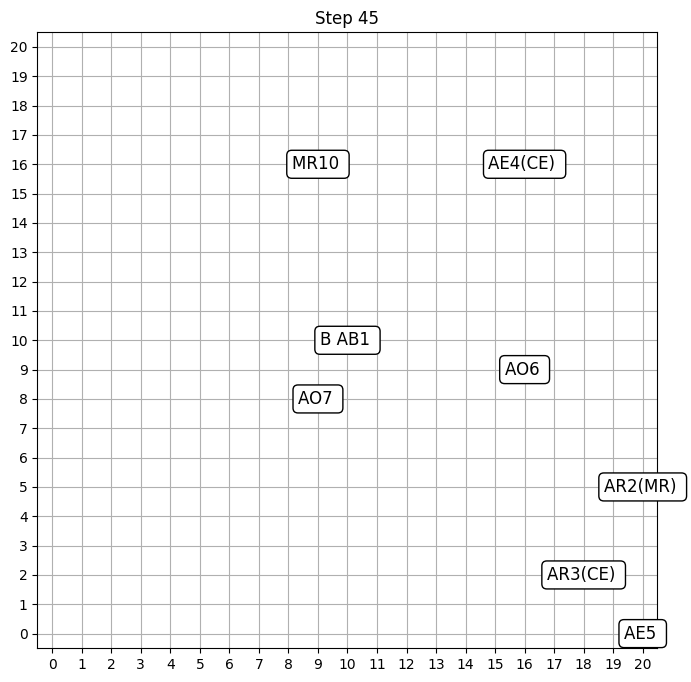

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (6, 20) is of class ReativoSimples
Agent 3 at position (1, 18) is of class ReativoSimples
Agent 4 at position (16, 15) is of class AgentEstados
Agent 5 at position (0, 19) is of class AgentEstados
Agent 6 at position (8, 17) is of class AgentObjetivo
Agent 7 at position (9, 10) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


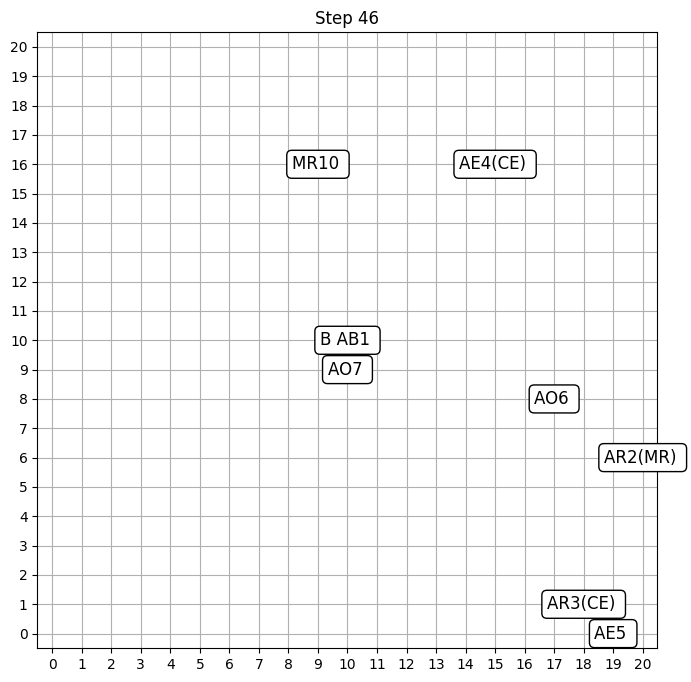

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (5, 20) is of class ReativoSimples
Agent 3 at position (2, 18) is of class ReativoSimples
Agent 4 at position (15, 15) is of class AgentEstados
Agent 5 at position (1, 18) is of class AgentEstados
Agent 6 at position (9, 18) is of class AgentObjetivo
Agent 7 at position (8, 11) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


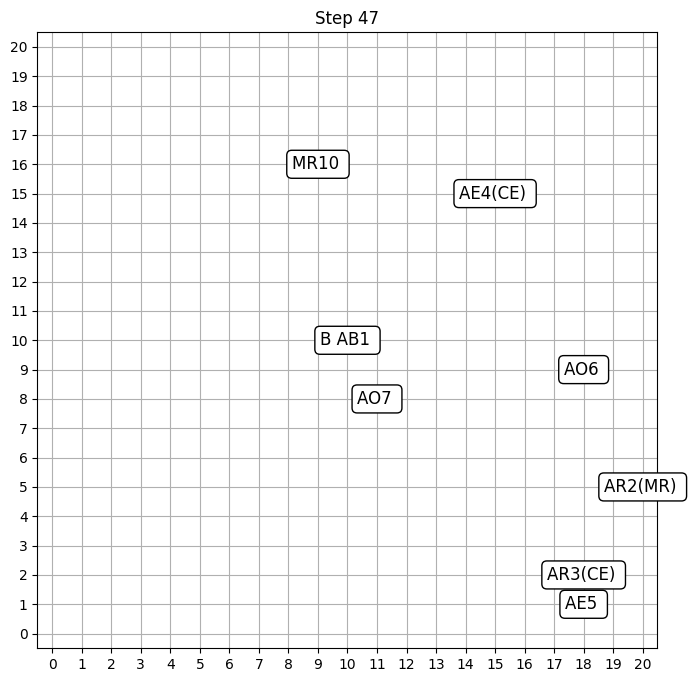

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (4, 20) is of class ReativoSimples
Agent 3 at position (3, 19) is of class ReativoSimples
Agent 4 at position (14, 14) is of class AgentEstados
Agent 5 at position (1, 17) is of class AgentEstados
Agent 6 at position (10, 17) is of class AgentObjetivo
Agent 7 at position (8, 12) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


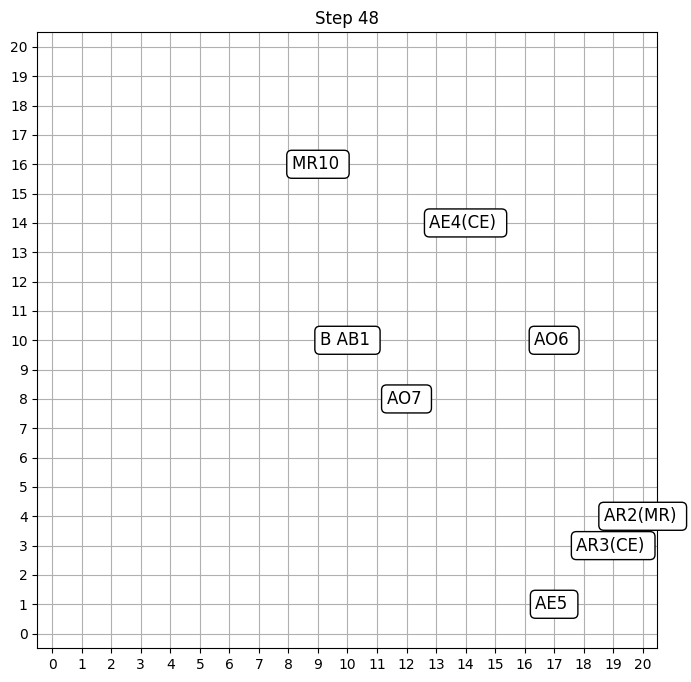

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}
Agent 2 at position (3, 19) is of class ReativoSimples
Agent 3 at position (2, 20) is of class ReativoSimples
Agent 4 at position (15, 14) is of class AgentEstados
Agent 5 at position (0, 16) is of class AgentEstados
Agent 6 at position (11, 18) is of class AgentObjetivo
Agent 7 at position (7, 11) is of class AgentObjetivo
Agent 1 at position (10, 10) is of class AgentBDI


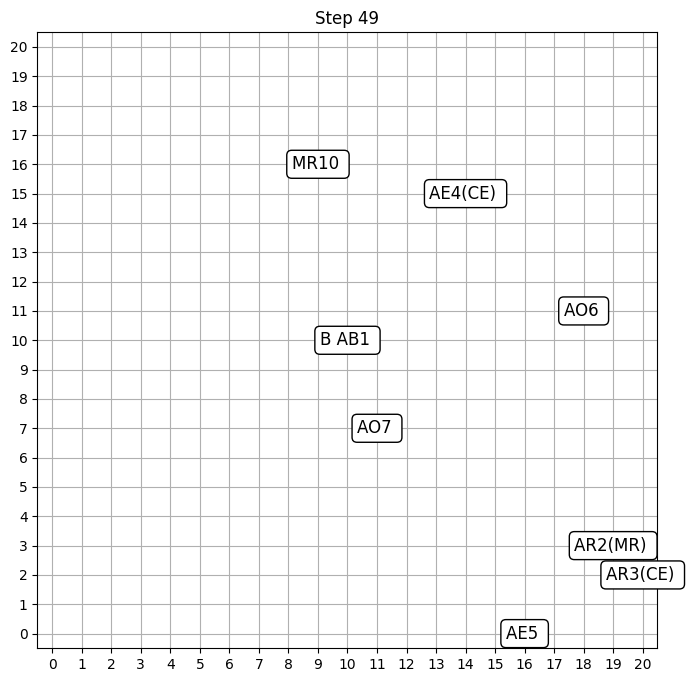

AR2 tem: Metal Raro9
AR3 tem: Cristal Energético14
AE4 tem: Cristal Energético16
AO6 tem o destino: None
AO6 procurando Destino
destino = None, None
AO7 tem o destino: None
AO7 procurando Destino
destino = None, None
{'CE': {}, 'MR': {}, 'EA': {}, 'I': {}}


In [ ]:
# Parameters
num_agents = 2
width = 21
height = 21
cristais_pos = [(11,13), (13,8), (6,8), (9,15), (12,12)]
metais_pos = [(5,16), (8,14), (16,9), (9,9)]
estruturas_old_pos = []
num_steps = 50
base = (10, 10)

# Create the model
model = RandomWalkModel(num_agents, width, height, cristais_pos, metais_pos, estruturas_old_pos, base)

# Run the model and visualize each step with adjustable image size
fig_width = 8  # Adjust figure width
fig_height = 8  # Adjust figure height
for step in range(num_steps):
    visualize_model(model, step, fig_width, fig_height)
    model.step()
visualize_model(model, step, fig_width, fig_height)

In [94]:
print(f"Contribuição total: {model.contribuicao_total}")
for agent in model.schedule.agents:
    #if isinstance(agent,ReativoSimples):
    nome = agent.nome
    print(f"Contribuição utilidade do agente {nome}: {agent.contribuicao}")
    print(f"Contribuição quantidade do agente {nome}: {agent.num_contribuicao}\n")

Contribuição total: 70
Contribuição utilidade do agente AR2: 20
Contribuição quantidade do agente AR2: 1

Contribuição utilidade do agente AR3: 0
Contribuição quantidade do agente AR3: 0

Contribuição utilidade do agente AE4: 0
Contribuição quantidade do agente AE4: 0

Contribuição utilidade do agente AE5: 0
Contribuição quantidade do agente AE5: 0

Contribuição utilidade do agente AO6: 20
Contribuição quantidade do agente AO6: 1

Contribuição utilidade do agente AO7: 30
Contribuição quantidade do agente AO7: 3

Contribuição utilidade do agente AB1: 70
Contribuição quantidade do agente AB1: 5

